In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import scipy as sp
from eden.util import configure_logging
import logging
logger = logging.getLogger()
configure_logging(logger,verbosity=2)

from IPython.core.display import HTML
HTML('<style>.container { width:95% !important; }</style><style>.output_png {display: table-cell;text-align: center;vertical-align: middle;}</style>')

In [2]:
from toolz import curry, pipe
from eden_chem.io.pubchem import download
from eden_chem.obabel import load as babel_load
from eden_chem.io.rdkitutils import sdf_to_nx

download_active = curry(download)(active=True)
download_inactive = curry(download)(active=False)

convert = babel_load
convert = sdf_to_nx
def get_pos_graphs(assay_id): return pipe(assay_id, download_active, convert, list)
def get_neg_graphs(assay_id): return pipe(assay_id, download_inactive, convert, list)

In [3]:
def bar(line, sep='-'):
    logger.info(sep*80)
    logger.info(line) 
    logger.info('_'*80)

In [4]:
from constrActive.utils import pre_process
from constrActive.utils import _random_sample

def make_data(assay_id, max_size=20):
    bar('Positive graphs')
    all_pos_graphs = get_pos_graphs(assay_id)
    args=dict(initial_max_size=2000, fraction_to_remove=.2, n_neighbors_for_outliers=3, remove_similar=True, max_size=max_size)
    pos_graphs = pre_process(all_pos_graphs, **args)
    return pos_graphs

In [15]:
from eden.graph import Vectorizer
from sklearn.neighbors import NearestNeighbors
import random

class InstanceMaker(object):
    """InstanceMaker."""

    def __init__(self, n_landmarks=5, n_neighbors=50):
        """init."""
        self.vec = Vectorizer(r=3, d=6,normalization=False, inner_normalization=False)
        self.n_neighbors = n_neighbors
        self.n_landmarks = n_landmarks
        
    def fit(self, graphs):
        self.graphs = graphs
        vecs = self.vec.transform(self.graphs)
        self.nn = NearestNeighbors(n_neighbors=self.n_neighbors).fit(vecs)
        return self

    def sample(self):
        target_graph = random.sample(self.graphs,1)[0]
        target_vec = self.vec.transform([target_graph])
        distances, neighbors = self.nn.kneighbors(target_vec, return_distance=True)
        distances = distances[0][1:]
        neighbors = neighbors[0][1:]
        ranked_graphs = [self.graphs[i] for i in neighbors]
        landmark_graphs = ranked_graphs[:self.n_landmarks]
        desired_distances = distances[:self.n_landmarks]
        for i,g in enumerate(ranked_graphs): g.graph['id']='id%d'%i
        return landmark_graphs, desired_distances, ranked_graphs, target_graph

In [6]:
from eden.graph import Vectorizer

def sort_by_distance_to_target(pareto_set_graphs, target_graph):
    vec = Vectorizer(r=3, d=6,normalization=False, inner_normalization=False)
    pareto_set_vecs = vec.transform(pareto_set_graphs)
    nn = NearestNeighbors(n_neighbors=len(pareto_set_graphs)).fit(pareto_set_vecs) 
    reference_vec = vec.transform([target_graph])
    distances, neighbors = nn.kneighbors(reference_vec,return_distance=True)
    distances = distances[0]
    neighbors = neighbors[0]

    reconstructions = []
    for i,d in zip(neighbors, distances):
        g = pareto_set_graphs[i]
        g.graph['id'] = '%.2f'%(d)
        reconstructions.append(g)
    return reconstructions

In [7]:
from IPython.core.display import display
from eden_chem.display.rdkitutils import nx_to_image

def draw_mols(graphs, num=15, n_graphs_per_line=7):
    titles = [graph.graph.get('id',i) for i, graph in enumerate(graphs)]
    img = nx_to_image(graphs[:num], n_graphs_per_line=n_graphs_per_line, titles=titles)
    display(img)

In [8]:
def annotate_distance(target_graph, reference_graphs, desired_distances):
    target_graph.graph['id']='%.2f'%0
    print('target + nearest neighbors')
    refs = []
    for g,d in zip(reference_graphs, desired_distances):
        g.graph['id']='%.2f'%d
        refs.append(g)

In [9]:
def visualize(target_graph, reconstructions, sorted_reconstructions, knn_graphs, n_graphs_per_line=8):
    configure_logging(logger,verbosity=1)
    bar('target vs candidate vs best vs 1-knn')
    graphs = [target_graph,reconstructions[0],sorted_reconstructions[0],knn_graphs[0]]
    draw_mols(graphs, num=len(graphs), n_graphs_per_line=len(graphs))

    bar('sorted reconstructions')
    draw_mols([target_graph]+sorted_reconstructions, num=n_graphs_per_line*3, n_graphs_per_line=n_graphs_per_line)
    bar('knns')
    draw_mols([target_graph]+knn_graphs, num=n_graphs_per_line*3, n_graphs_per_line=n_graphs_per_line)

In [10]:
from constrActive import construct_from_neighbors

def construct_and_visualize_exp(target_graph, landmark_graphs, desired_distances, ranked_graphs, args):
    configure_logging(logger,verbosity=2)
    reconstructions = construct_from_neighbors(
        landmark_graphs=landmark_graphs,
        desired_distances=desired_distances,
        ranked_graphs=ranked_graphs,
        **args)
    sorted_reconstructions = sort_by_distance_to_target(reconstructions, target_graph)
    knn_graphs = sort_by_distance_to_target(ranked_graphs, target_graph)
    visualize(target_graph, reconstructions, sorted_reconstructions, knn_graphs)
    return reconstructions

In [11]:
def iter_construct_and_visualize_exp(n_iter, target_graph, landmark_graphs, desired_distances, ranked_graphs, args):    
    reconstructions = None
    n=args['max_size_frontier']
    for i in range(n_iter):
        bar('iter: %d/%d'%(i+1, n_iter),'_')
        if reconstructions is not None:
            sorted_reconstructions = sort_by_distance_to_target(reconstructions, target_graph)
            _desired_distances = [float(g.graph['id']) for g in sorted_reconstructions]
            desired_distances = np.array(_desired_distances + list(desired_distances))
            landmark_graphs = sorted_reconstructions + landmark_graphs
            dist_land = [(d,g) for d, g in sorted(zip(desired_distances, landmark_graphs))[:n]]
            desired_distances, landmark_graphs = zip(*dist_land)
            desired_distances = np.array(desired_distances)
            landmark_graphs = list(landmark_graphs)
        reconstructions = construct_and_visualize_exp(target_graph, landmark_graphs, desired_distances, ranked_graphs, args)
    return reconstructions

---

In [12]:
%%time
configure_logging(logger,verbosity=2)
assay_ids=['492992','463230','588350','651610','624466','492952','463213','119','1224857','2326']
pos_graphs = make_data(assay_ids[0], max_size=1000)

--------------------------------------------------------------------------------
Positive graphs
________________________________________________________________________________
Reading from file: PUBCHEM/AID492992_active.sdf
original size:2094
random sample:2000
size filter:1800
outlier removal:1133
similar pairs removal:566
random sample:566
CPU times: user 17.6 s, sys: 304 ms, total: 17.9 s
Wall time: 17.8 s





Exp: 1/5
________________________________________________________________________________
iter: 1/4
________________________________________________________________________________
#interfaces:  2551   #cores:  2689   #core-interface-pairs:  4368
fitting: Instances: 7832 ; Features: 65537 with an avg of 1732 per instance
fit  2.94 sec
iter:   0 	current min obj-0:    2.70 	median obj-0:   10.56 	added n neighbors:  583 	obtained pareto set of size:   24 	next round seeds:   10 
iter:   1 	current min obj-0:    2.70 	median obj-0:    9.49 	added n neighbors:  440 	obtained pareto set of size:   30 	next round seeds:   10 
iter:   2 	current min obj-0:    2.08 	median obj-0:    9.07 	added n neighbors:  649 	obtained pareto set of size:   30 	next round seeds:    1 
Terminated at iteration:3 because No non visited elements in frontier, stopping
optimize  36.31 sec
--------------------------------------------------------------------------------
target vs candidate vs best vs 1-knn
____

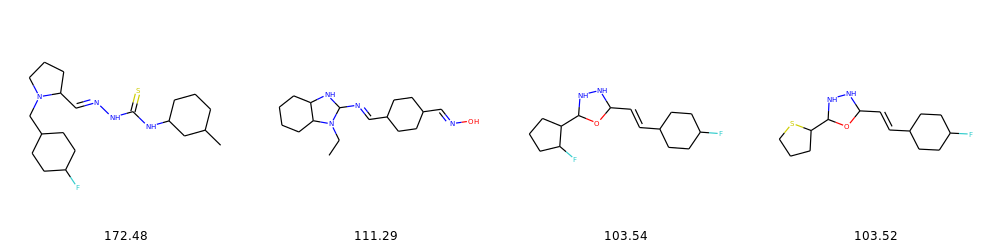

--------------------------------------------------------------------------------
sorted reconstructions
________________________________________________________________________________


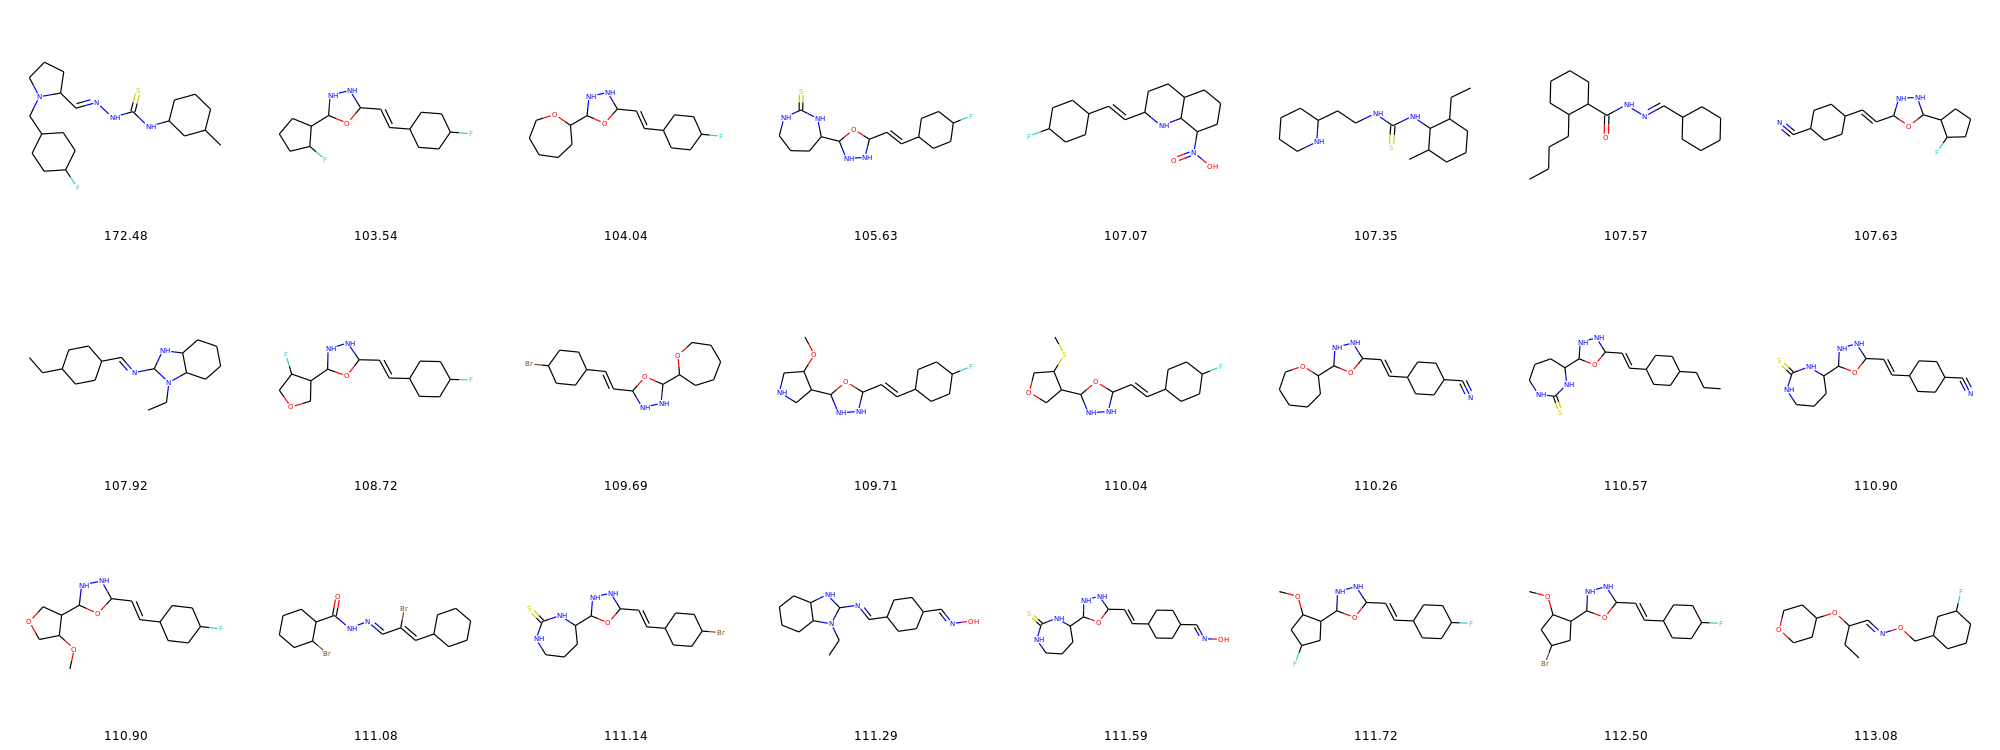

--------------------------------------------------------------------------------
knns
________________________________________________________________________________


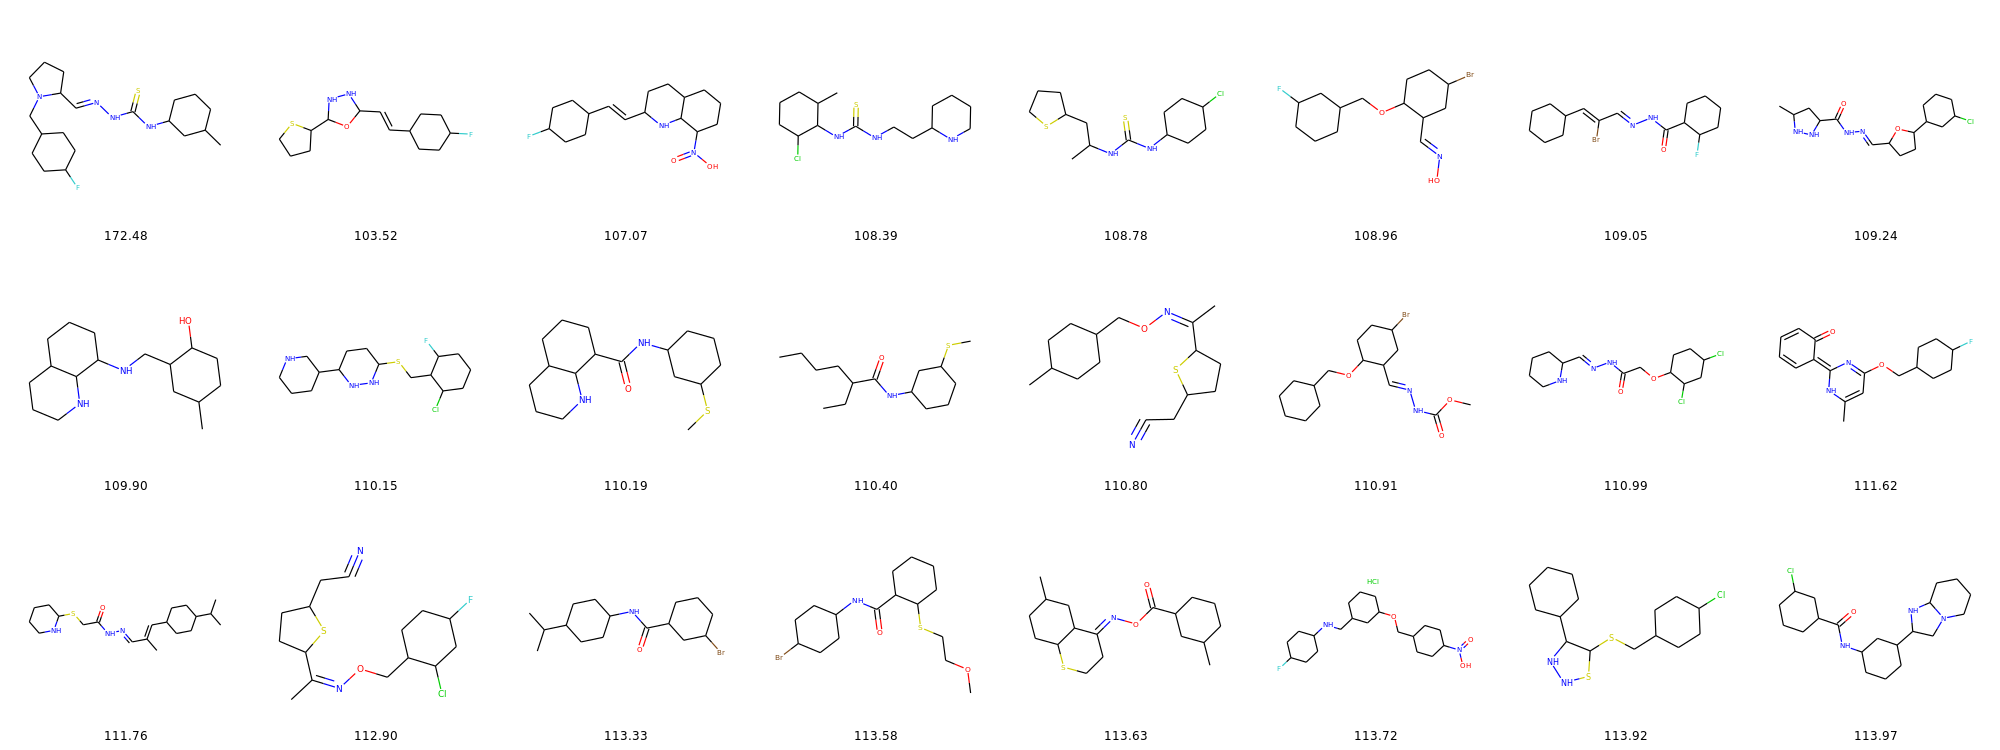

________________________________________________________________________________
iter: 2/4
________________________________________________________________________________
#interfaces:  2551   #cores:  2689   #core-interface-pairs:  4368
fitting: Instances: 7832 ; Features: 65537 with an avg of 1732 per instance
fit  2.72 sec
iter:   0 	current min obj-0:    2.28 	median obj-0:   12.11 	added n neighbors:  645 	obtained pareto set of size:   29 	next round seeds:   10 
iter:   1 	current min obj-0:    2.28 	median obj-0:   10.62 	added n neighbors:  565 	obtained pareto set of size:   18 	next round seeds:   10 
iter:   2 	current min obj-0:    2.28 	median obj-0:   13.88 	added n neighbors:  355 	obtained pareto set of size:   24 	next round seeds:    1 
Terminated at iteration:3 because No non visited elements in frontier, stopping
optimize  34.48 sec
--------------------------------------------------------------------------------
target vs candidate vs best vs 1-knn
________________

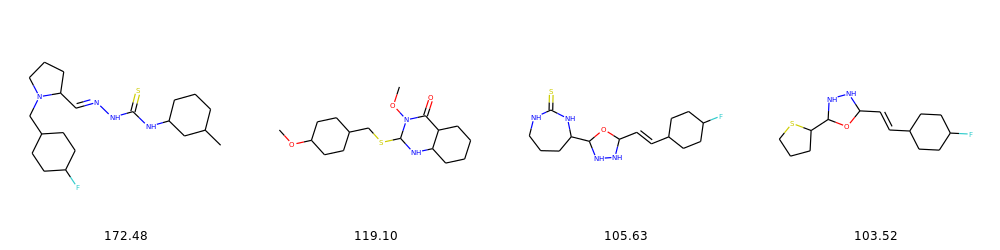

--------------------------------------------------------------------------------
sorted reconstructions
________________________________________________________________________________


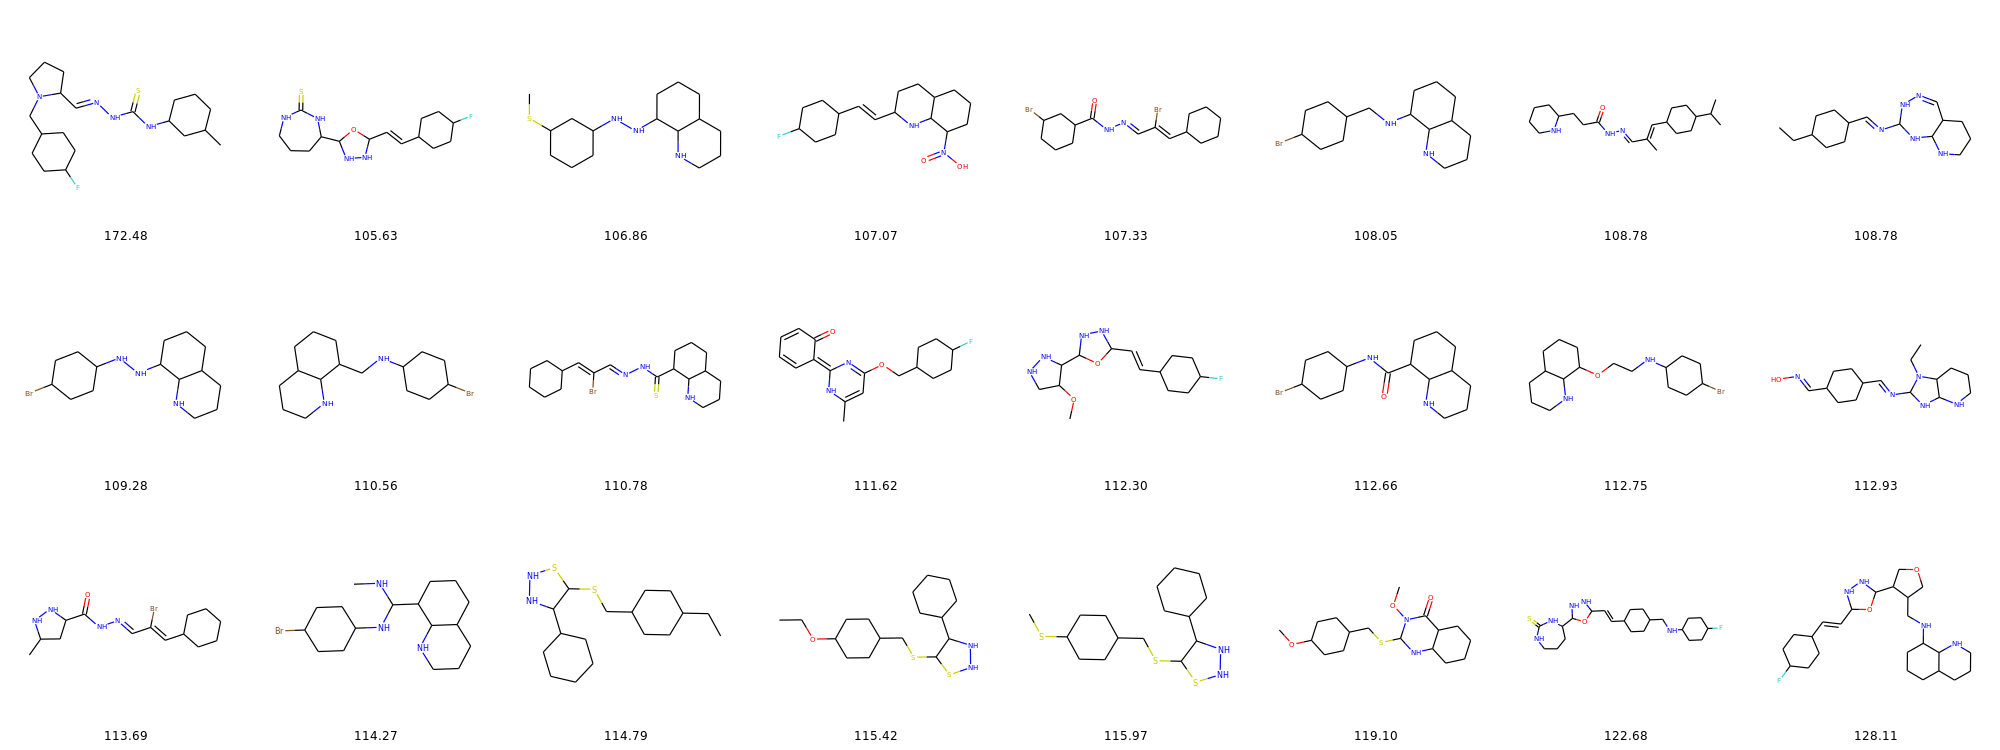

--------------------------------------------------------------------------------
knns
________________________________________________________________________________


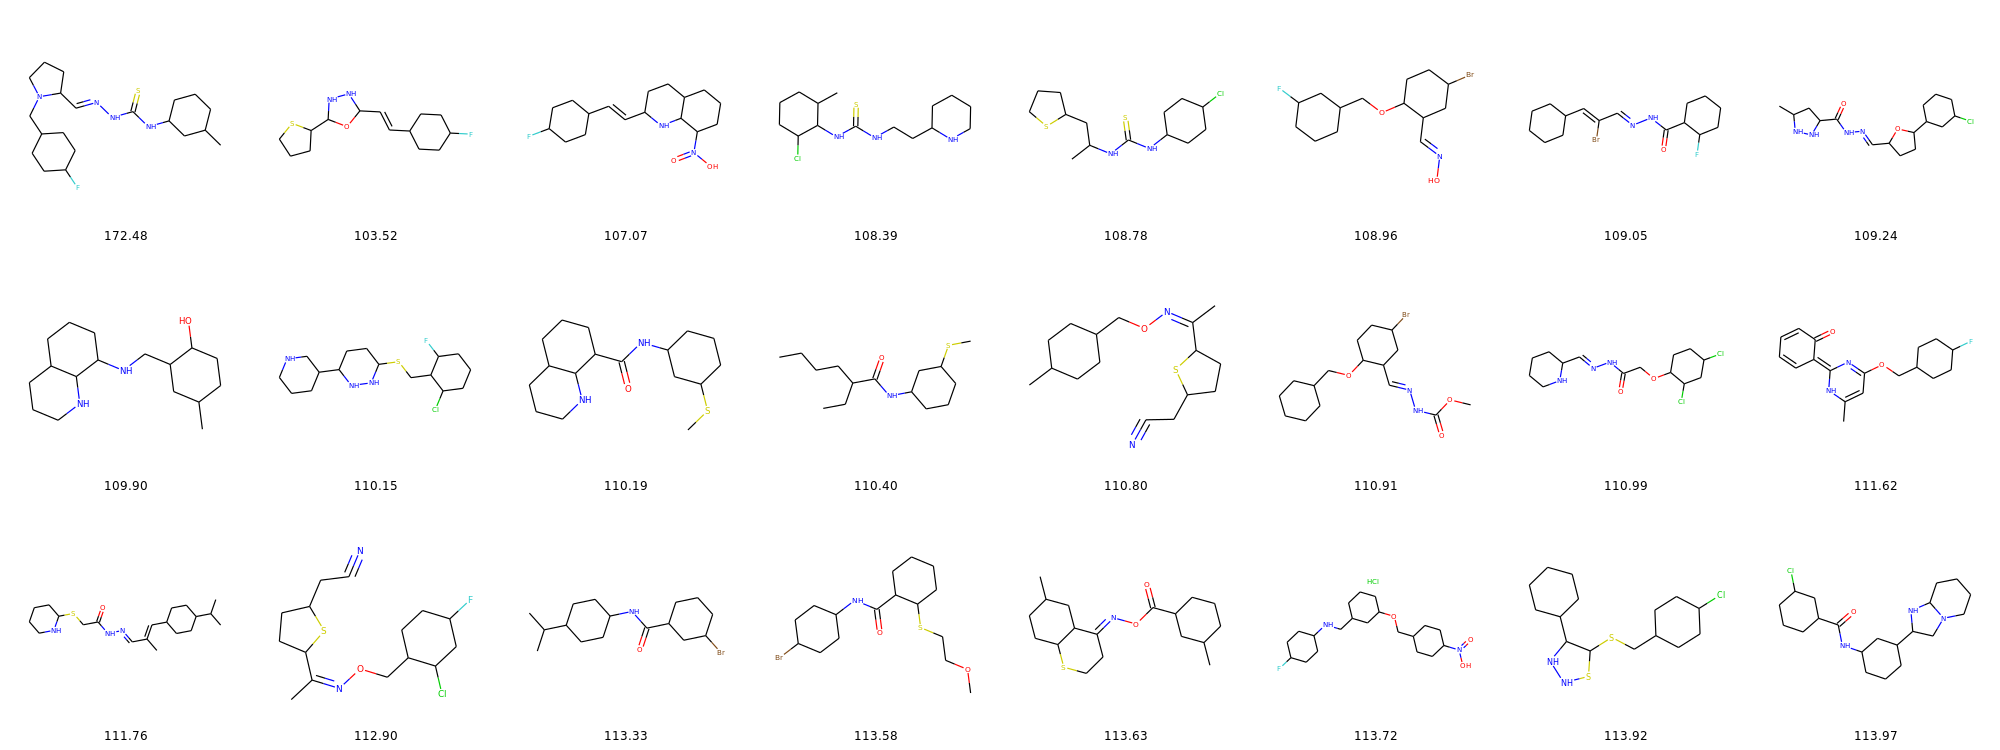

________________________________________________________________________________
iter: 3/4
________________________________________________________________________________
#interfaces:  2551   #cores:  2689   #core-interface-pairs:  4368
fitting: Instances: 7832 ; Features: 65537 with an avg of 1732 per instance
fit  3.01 sec
iter:   0 	current min obj-0:    2.50 	median obj-0:   10.07 	added n neighbors:  931 	obtained pareto set of size:   30 	next round seeds:   10 
iter:   1 	current min obj-0:    2.40 	median obj-0:    7.56 	added n neighbors:  959 	obtained pareto set of size:   29 	next round seeds:   10 
iter:   2 	current min obj-0:    2.05 	median obj-0:    8.10 	added n neighbors:  390 	obtained pareto set of size:   31 	next round seeds:    9 
iter:   3 	current min obj-0:    2.05 	median obj-0:    6.83 	added n neighbors:  453 	obtained pareto set of size:   30 	next round seeds:    2 
Terminated at iteration:4 because No non visited elements in frontier, stopping
optimize

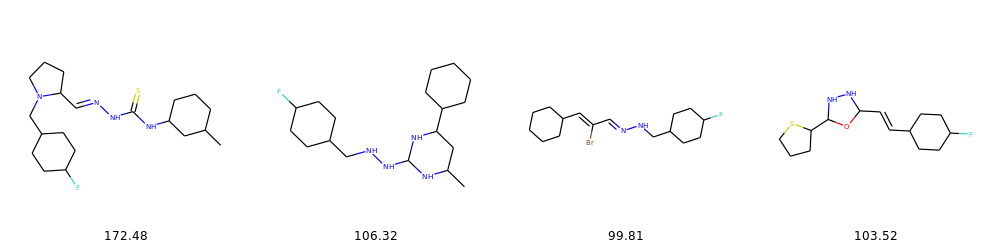

--------------------------------------------------------------------------------
sorted reconstructions
________________________________________________________________________________


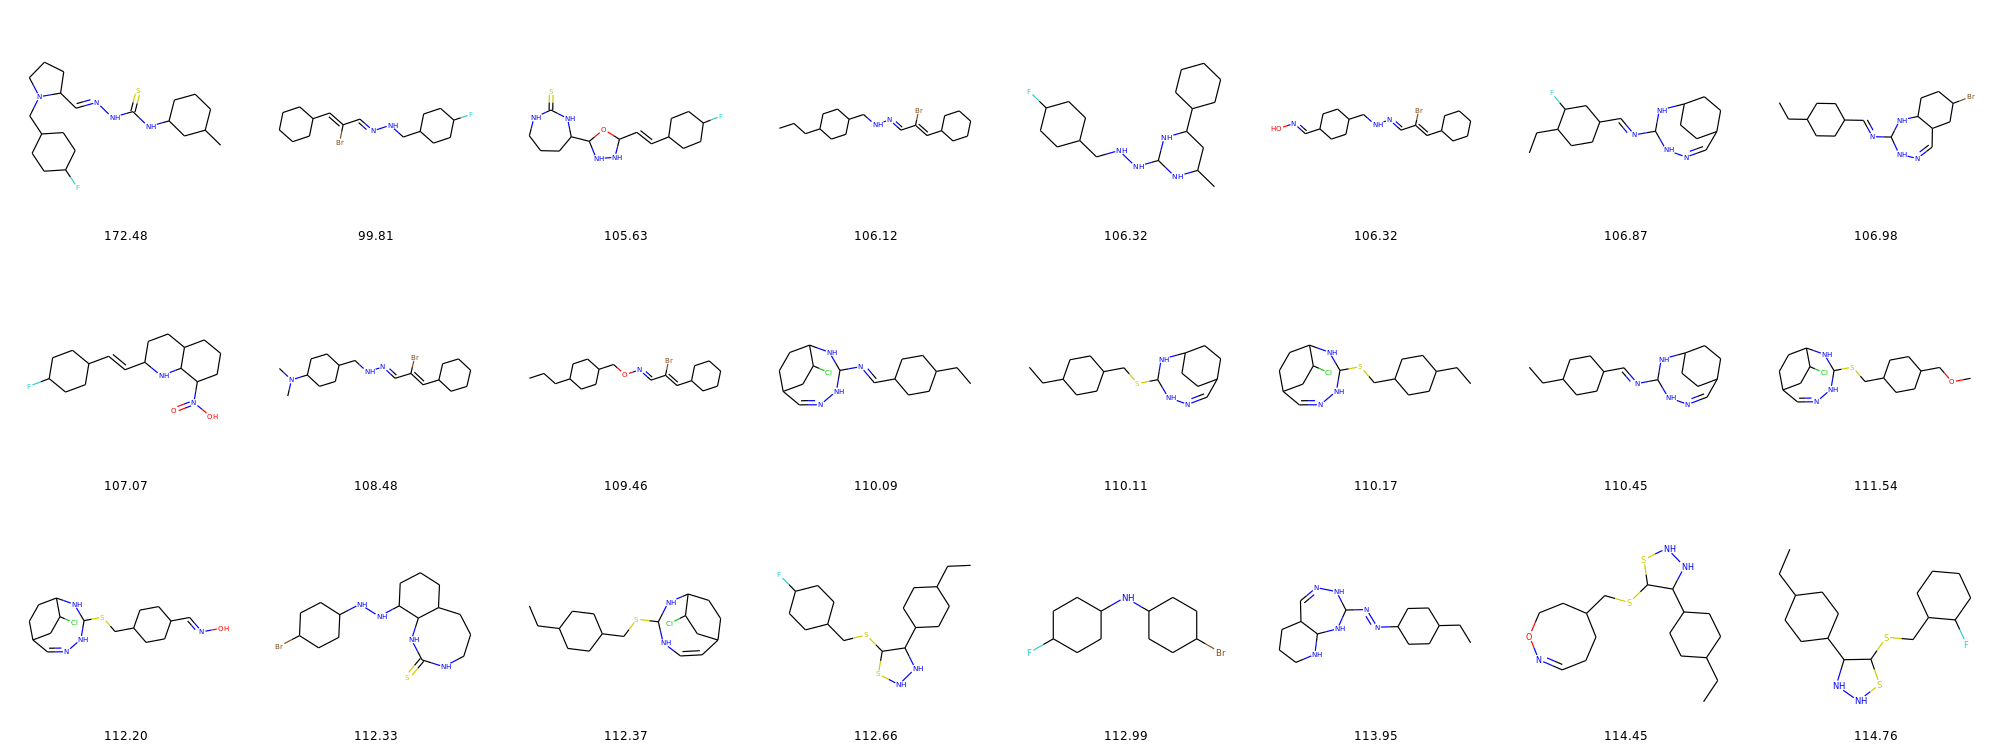

--------------------------------------------------------------------------------
knns
________________________________________________________________________________


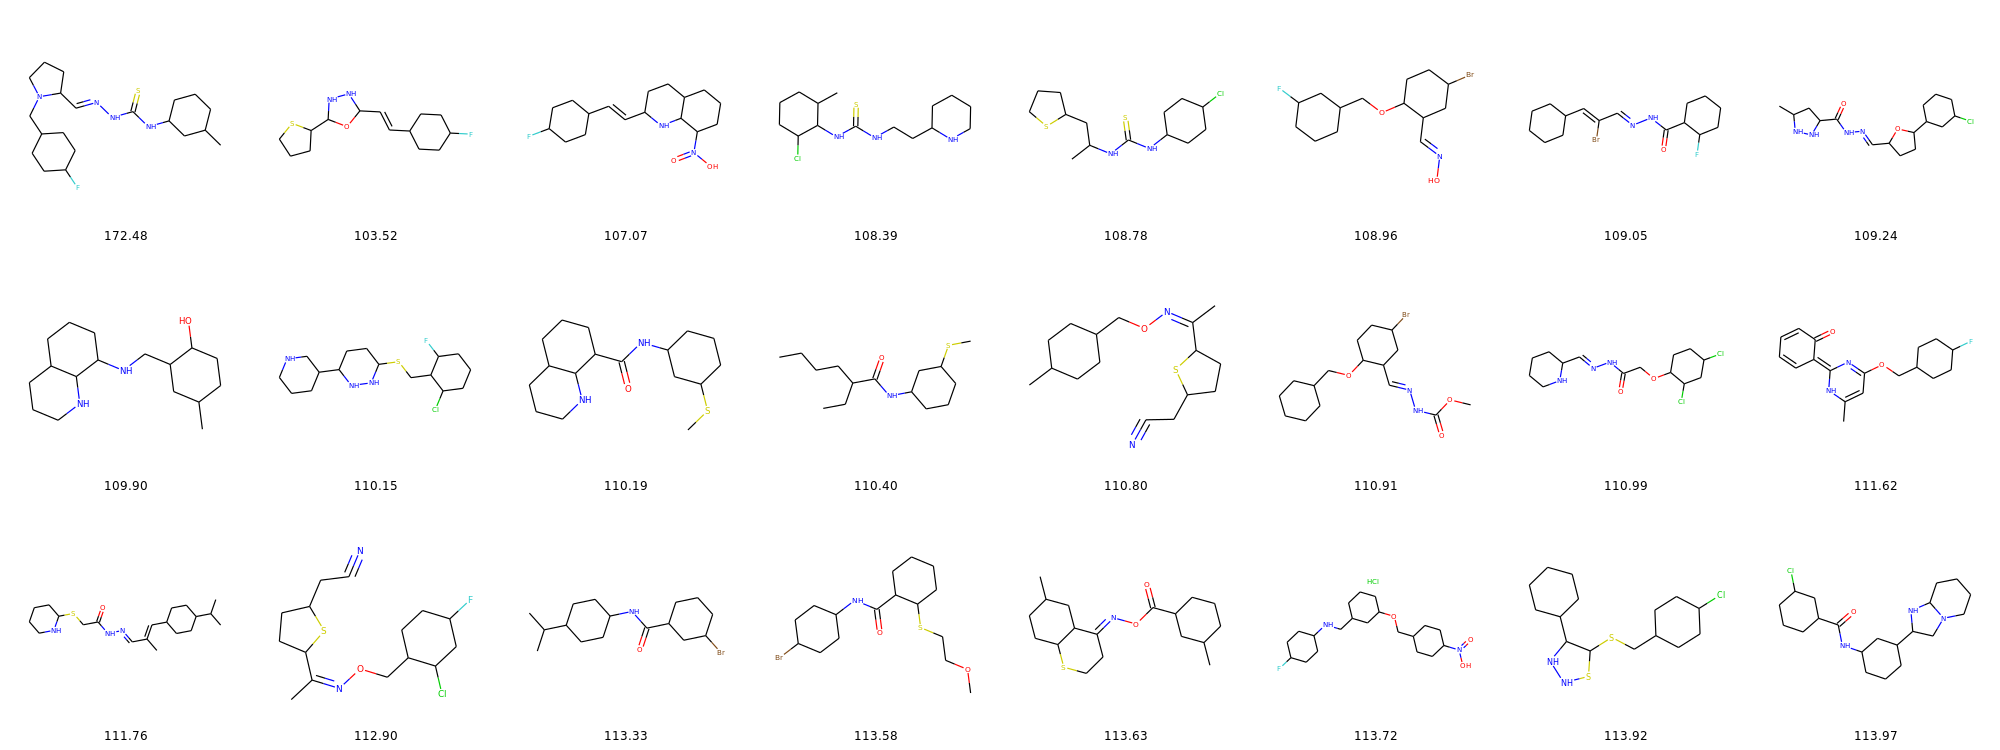

________________________________________________________________________________
iter: 4/4
________________________________________________________________________________
#interfaces:  2551   #cores:  2689   #core-interface-pairs:  4368
fitting: Instances: 7832 ; Features: 65537 with an avg of 1732 per instance
fit  2.78 sec
iter:   0 	current min obj-0:    2.99 	median obj-0:    9.57 	added n neighbors: 1216 	obtained pareto set of size:   30 	next round seeds:   10 
iter:   1 	current min obj-0:    2.14 	median obj-0:    8.56 	added n neighbors:  847 	obtained pareto set of size:   18 	next round seeds:    8 
iter:   2 	current min obj-0:    2.14 	median obj-0:    7.22 	added n neighbors: 1158 	obtained pareto set of size:   26 	next round seeds:    4 
Terminated at iteration:3 because No non visited elements in frontier, stopping
optimize  58.10 sec
--------------------------------------------------------------------------------
target vs candidate vs best vs 1-knn
________________

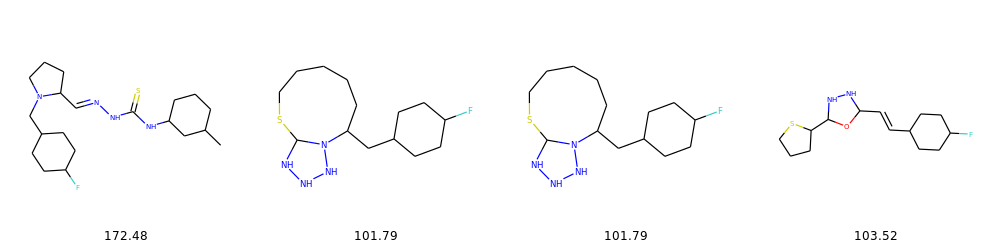

--------------------------------------------------------------------------------
sorted reconstructions
________________________________________________________________________________


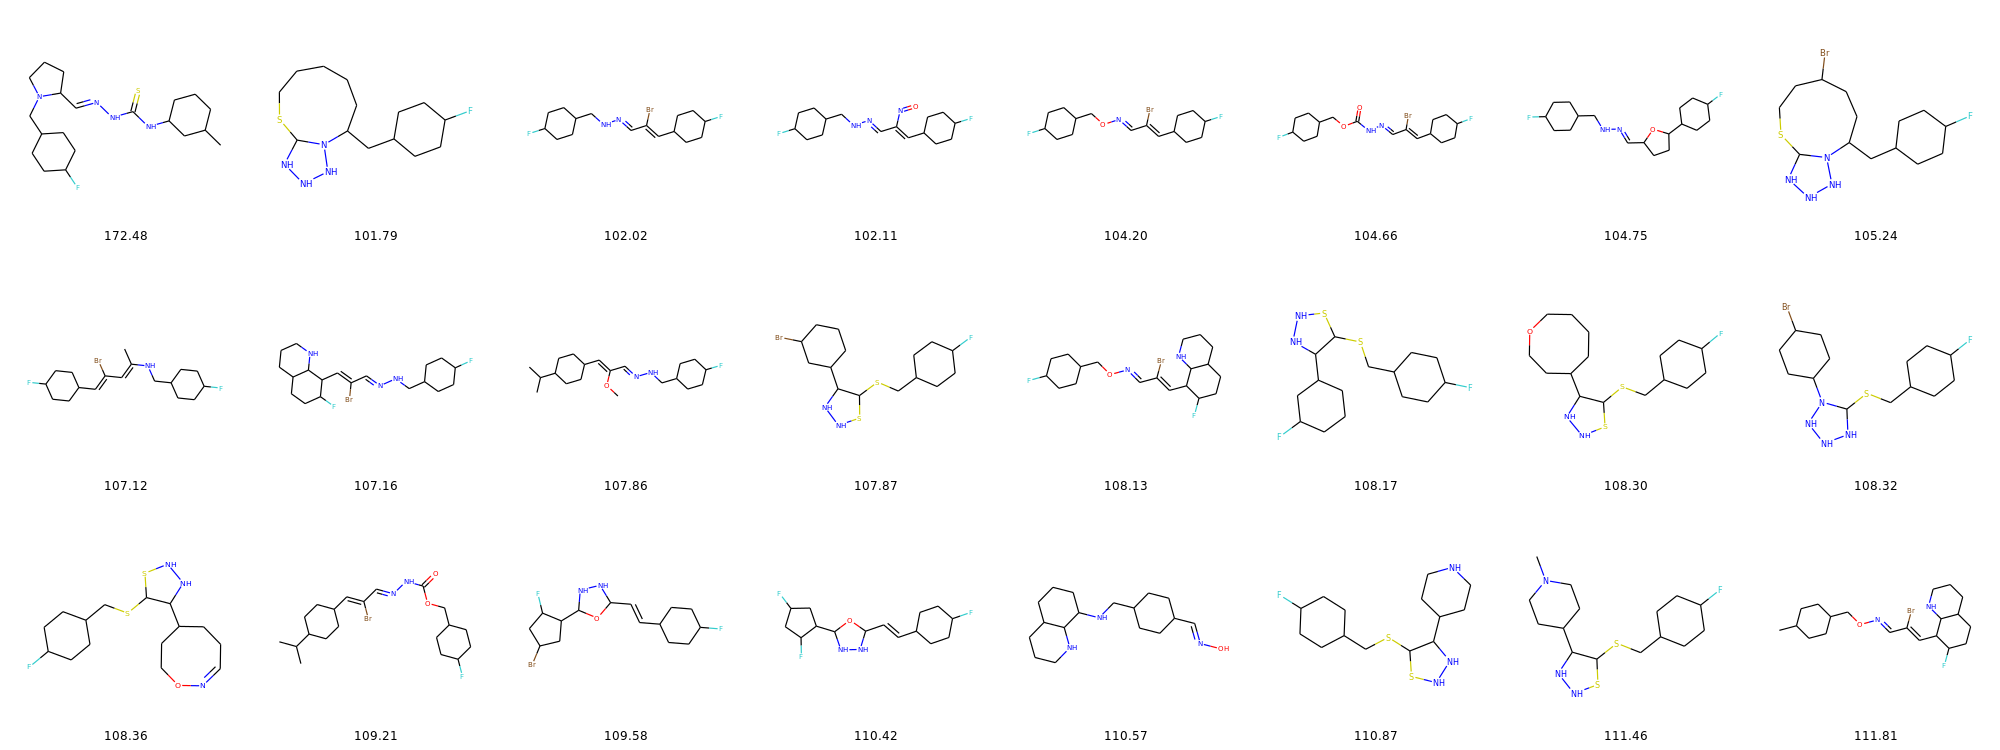

--------------------------------------------------------------------------------
knns
________________________________________________________________________________


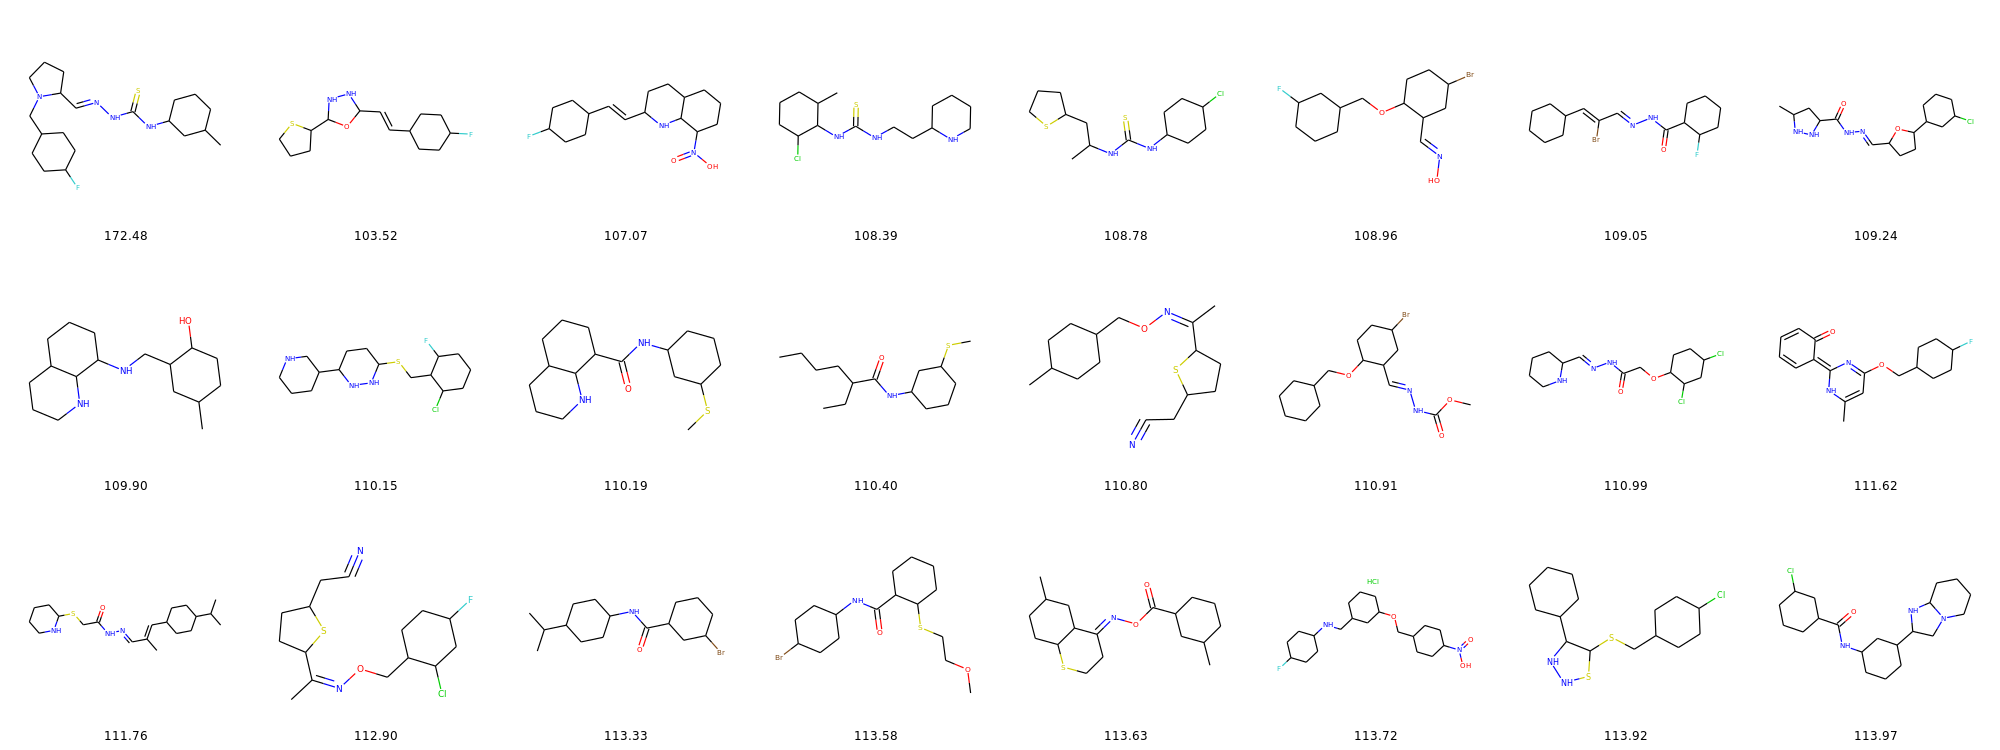




Exp: 2/5
________________________________________________________________________________
iter: 1/4
________________________________________________________________________________
#interfaces:  2910   #cores:  3054   #core-interface-pairs:  4908
fitting: Instances: 7832 ; Features: 65537 with an avg of 2044 per instance
fit  3.56 sec
iter:   0 	current min obj-0:    6.15 	median obj-0:   15.45 	added n neighbors:  413 	obtained pareto set of size:   28 	next round seeds:   10 
iter:   1 	current min obj-0:    5.20 	median obj-0:   20.50 	added n neighbors:  779 	obtained pareto set of size:   32 	next round seeds:   10 
iter:   2 	current min obj-0:    5.00 	median obj-0:   17.94 	added n neighbors:  323 	obtained pareto set of size:   31 	next round seeds:    3 
iter:   3 	current min obj-0:    5.00 	median obj-0:   14.19 	added n neighbors:   60 	obtained pareto set of size:   31 	next round seeds:    1 
Terminated at iteration:4 because No non visited elements in frontier, stopp

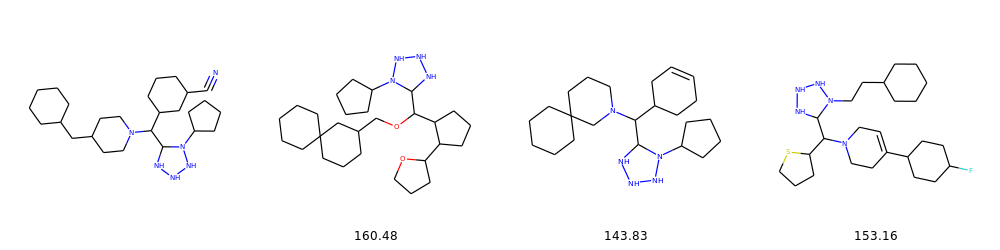

--------------------------------------------------------------------------------
sorted reconstructions
________________________________________________________________________________


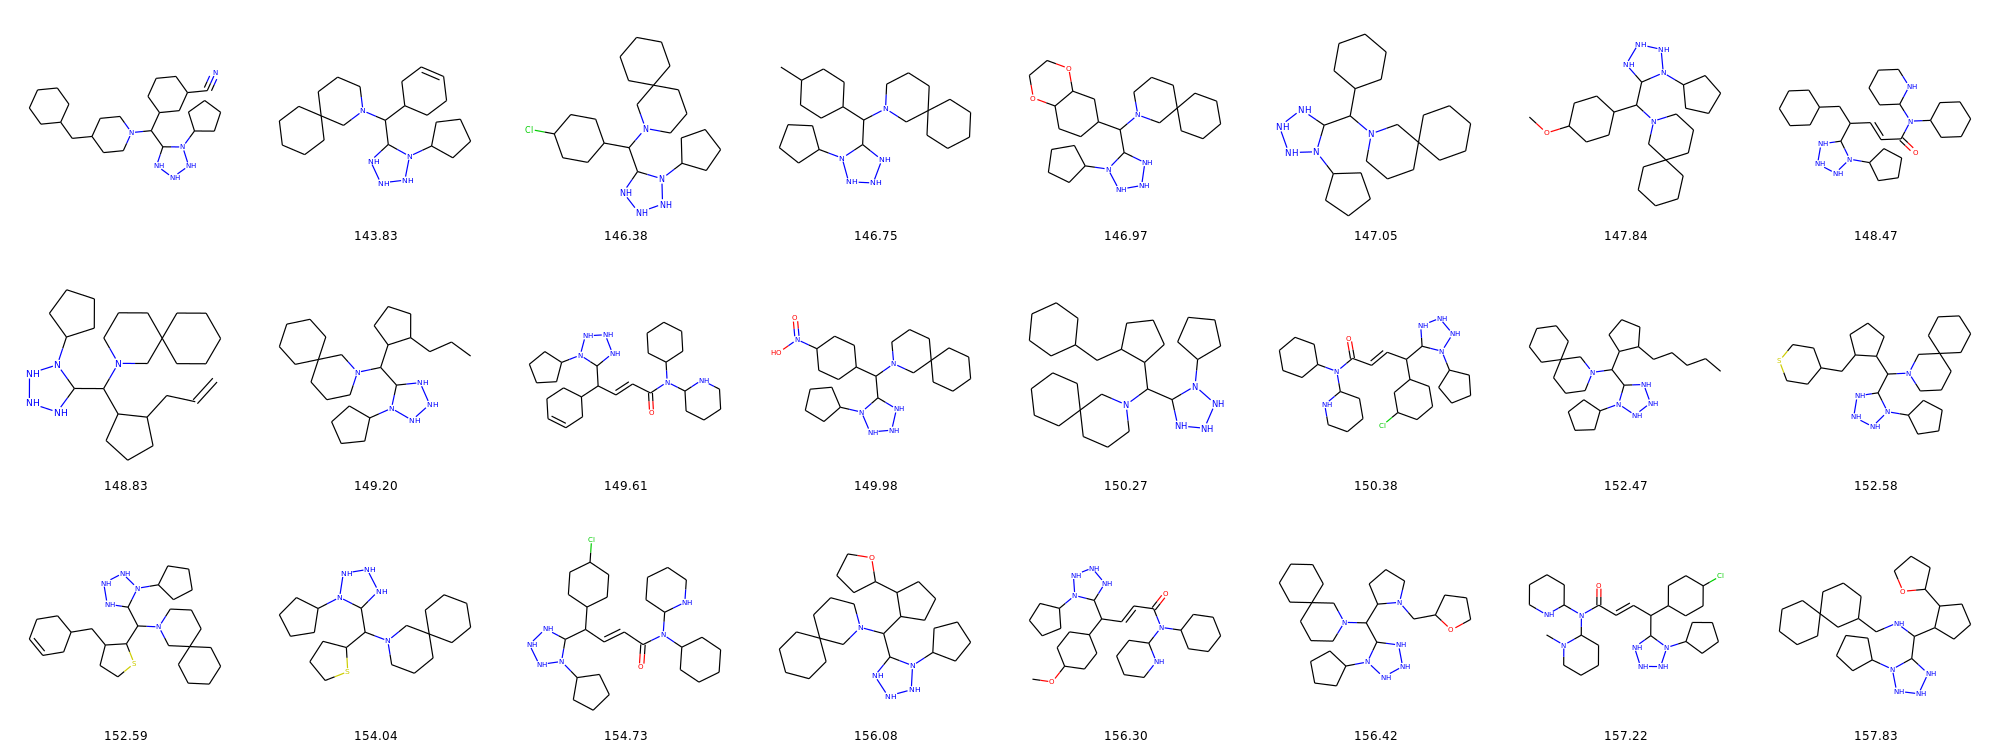

--------------------------------------------------------------------------------
knns
________________________________________________________________________________


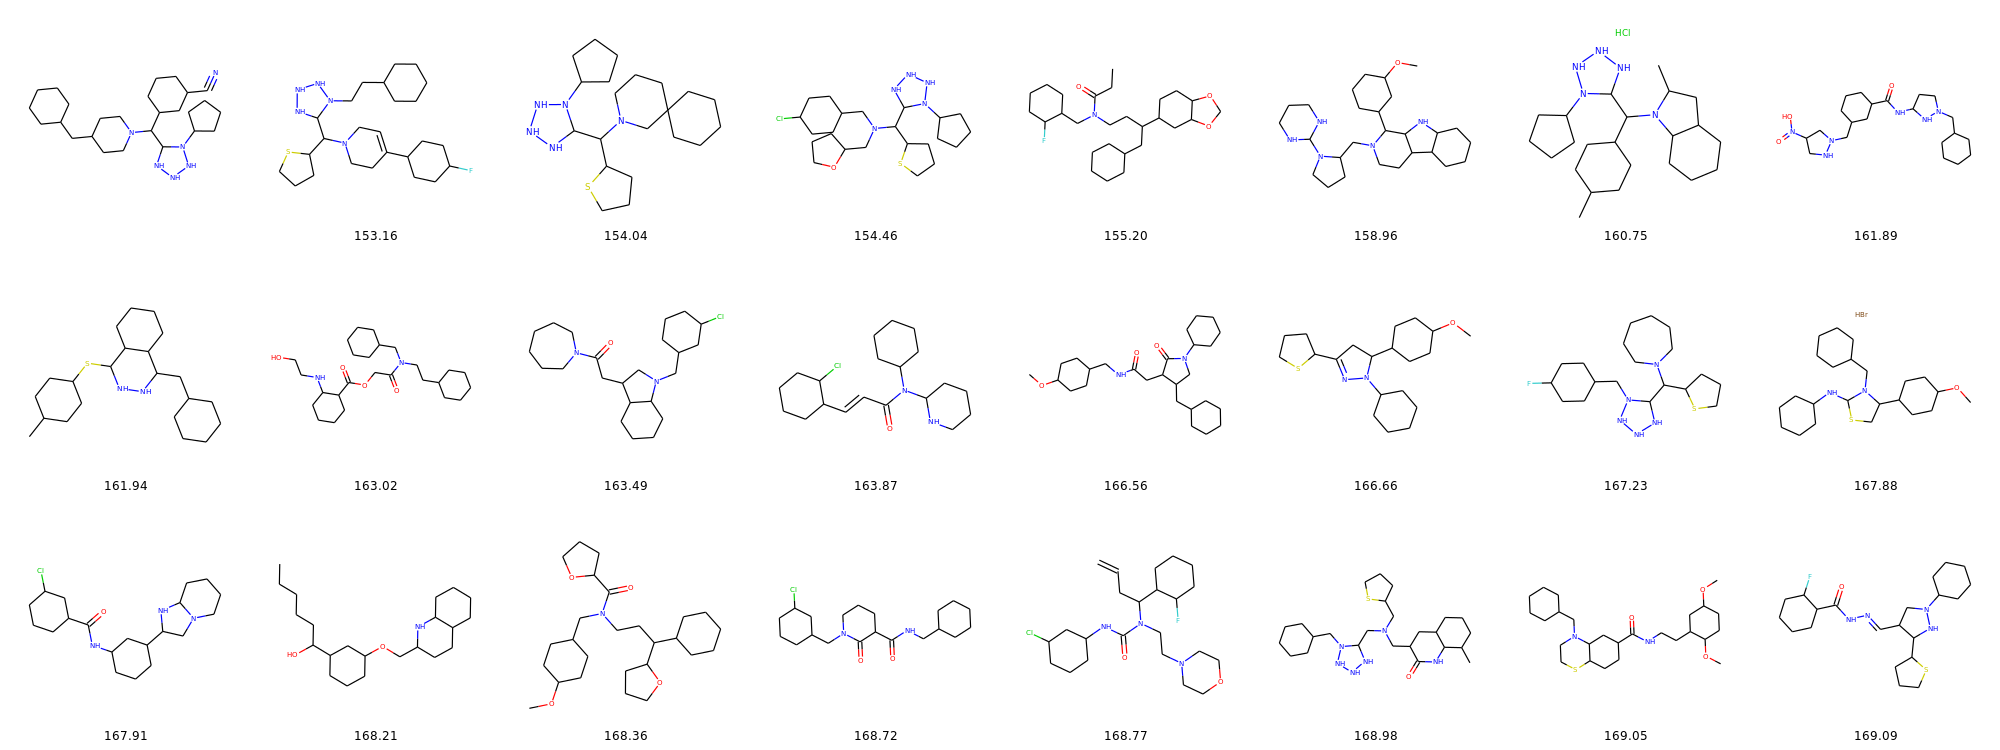

________________________________________________________________________________
iter: 2/4
________________________________________________________________________________
#interfaces:  2910   #cores:  3054   #core-interface-pairs:  4908
fitting: Instances: 7832 ; Features: 65537 with an avg of 2044 per instance
fit  3.23 sec
iter:   0 	current min obj-0:    7.72 	median obj-0:   25.35 	added n neighbors:  593 	obtained pareto set of size:   31 	next round seeds:   10 
iter:   1 	current min obj-0:    6.14 	median obj-0:   24.15 	added n neighbors:  336 	obtained pareto set of size:   31 	next round seeds:   10 
iter:   2 	current min obj-0:    6.02 	median obj-0:   25.08 	added n neighbors:  568 	obtained pareto set of size:   31 	next round seeds:    9 
iter:   3 	current min obj-0:    4.58 	median obj-0:   11.50 	added n neighbors:  701 	obtained pareto set of size:   31 	next round seeds:    3 
iter:   4 	current min obj-0:    3.86 	median obj-0:   11.70 	added n neighbors:  206 	o

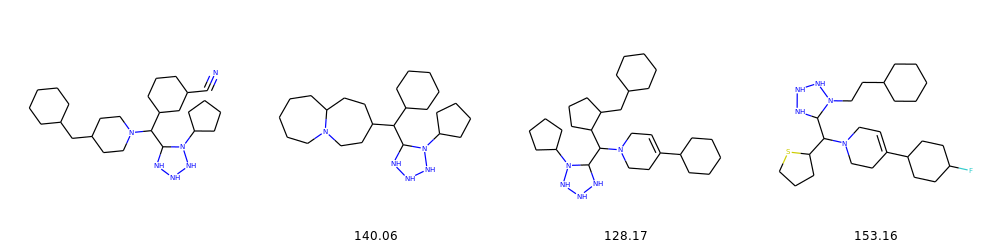

--------------------------------------------------------------------------------
sorted reconstructions
________________________________________________________________________________


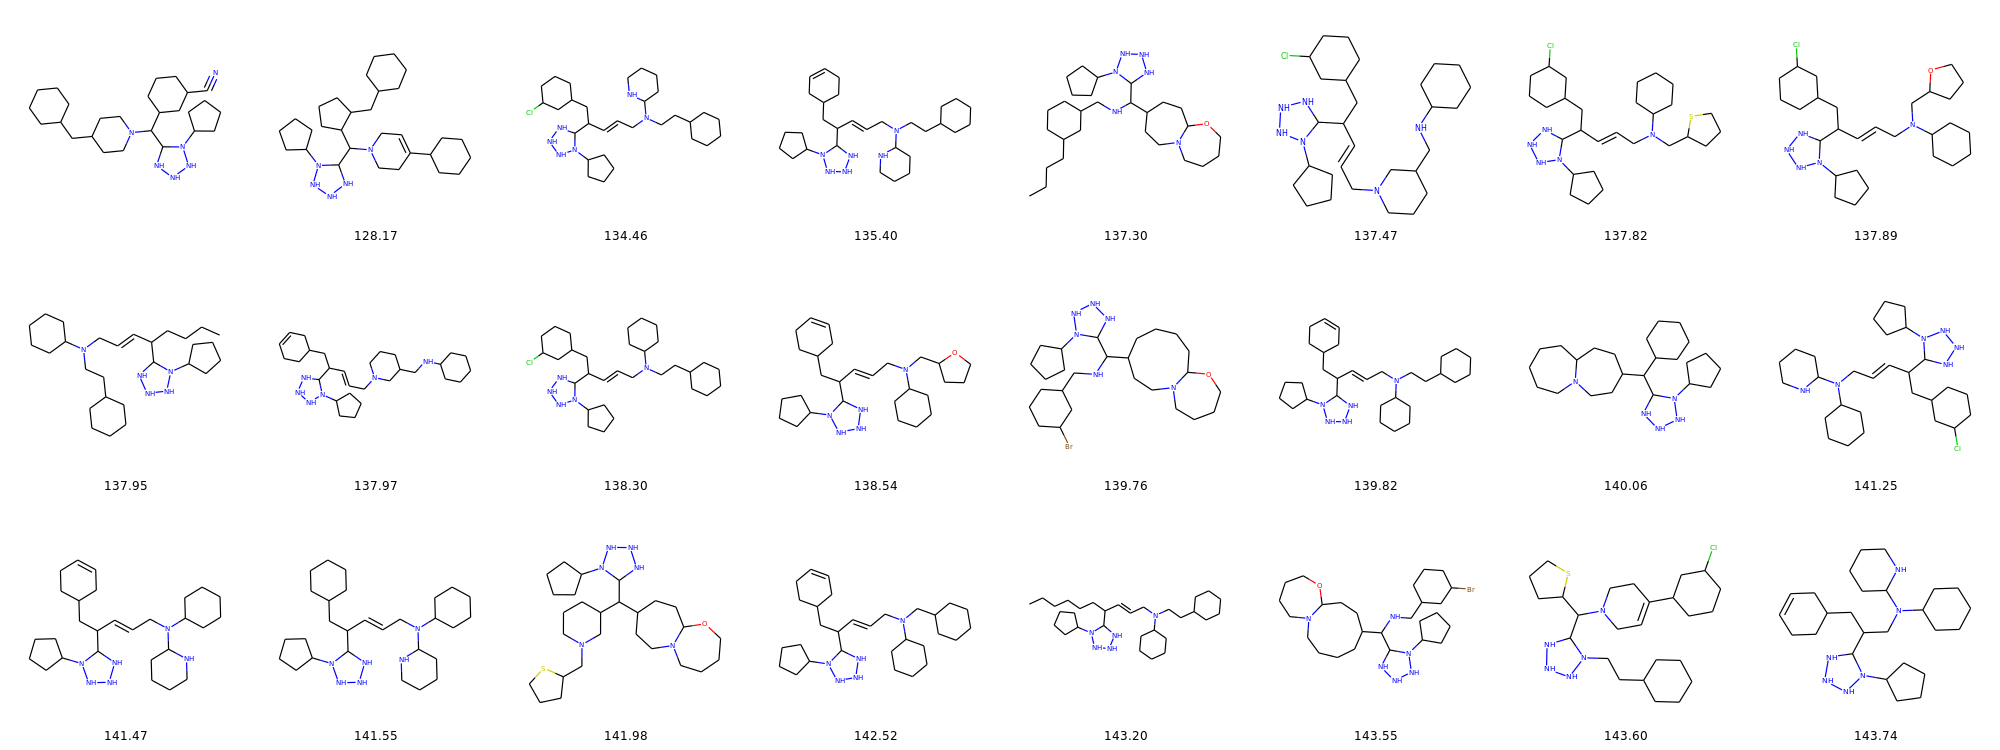

--------------------------------------------------------------------------------
knns
________________________________________________________________________________


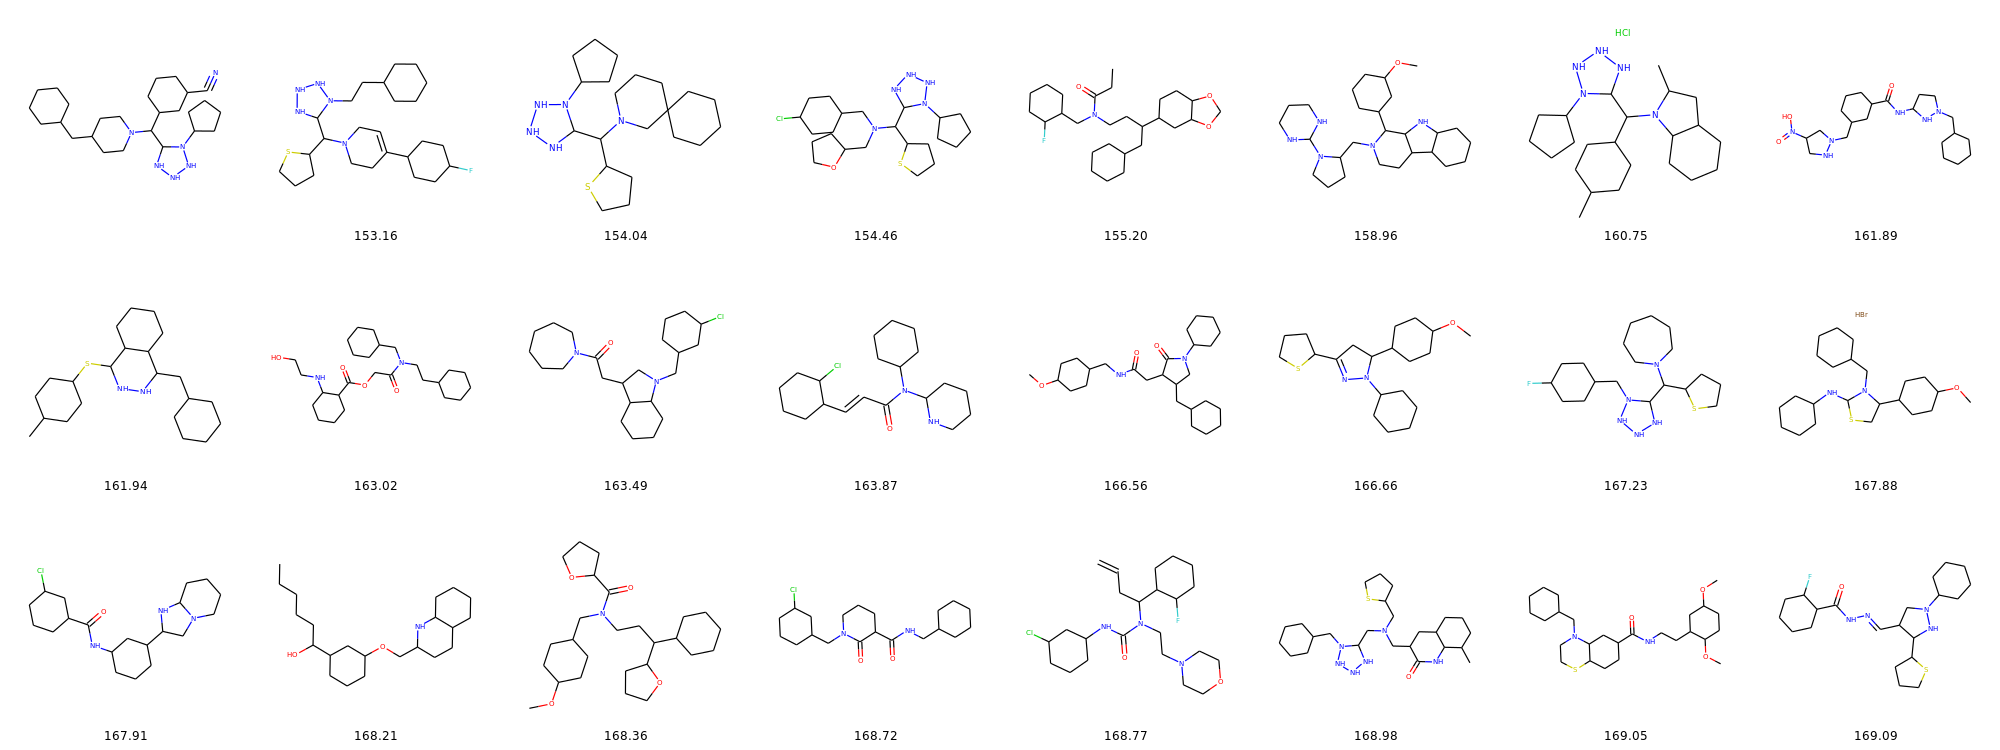

________________________________________________________________________________
iter: 3/4
________________________________________________________________________________
#interfaces:  2910   #cores:  3054   #core-interface-pairs:  4908
fitting: Instances: 7832 ; Features: 65537 with an avg of 2044 per instance
fit  3.28 sec
iter:   0 	current min obj-0:    4.44 	median obj-0:   23.23 	added n neighbors: 1084 	obtained pareto set of size:   31 	next round seeds:   10 
iter:   1 	current min obj-0:    4.44 	median obj-0:   28.69 	added n neighbors: 1446 	obtained pareto set of size:   31 	next round seeds:   10 
iter:   2 	current min obj-0:    4.44 	median obj-0:   39.54 	added n neighbors: 1113 	obtained pareto set of size:   31 	next round seeds:    6 
Terminated at iteration:3 because No non visited elements in frontier, stopping
optimize  172.50 sec
--------------------------------------------------------------------------------
target vs candidate vs best vs 1-knn
_______________

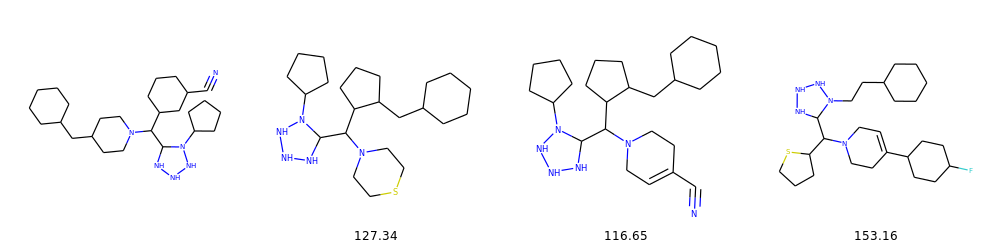

--------------------------------------------------------------------------------
sorted reconstructions
________________________________________________________________________________


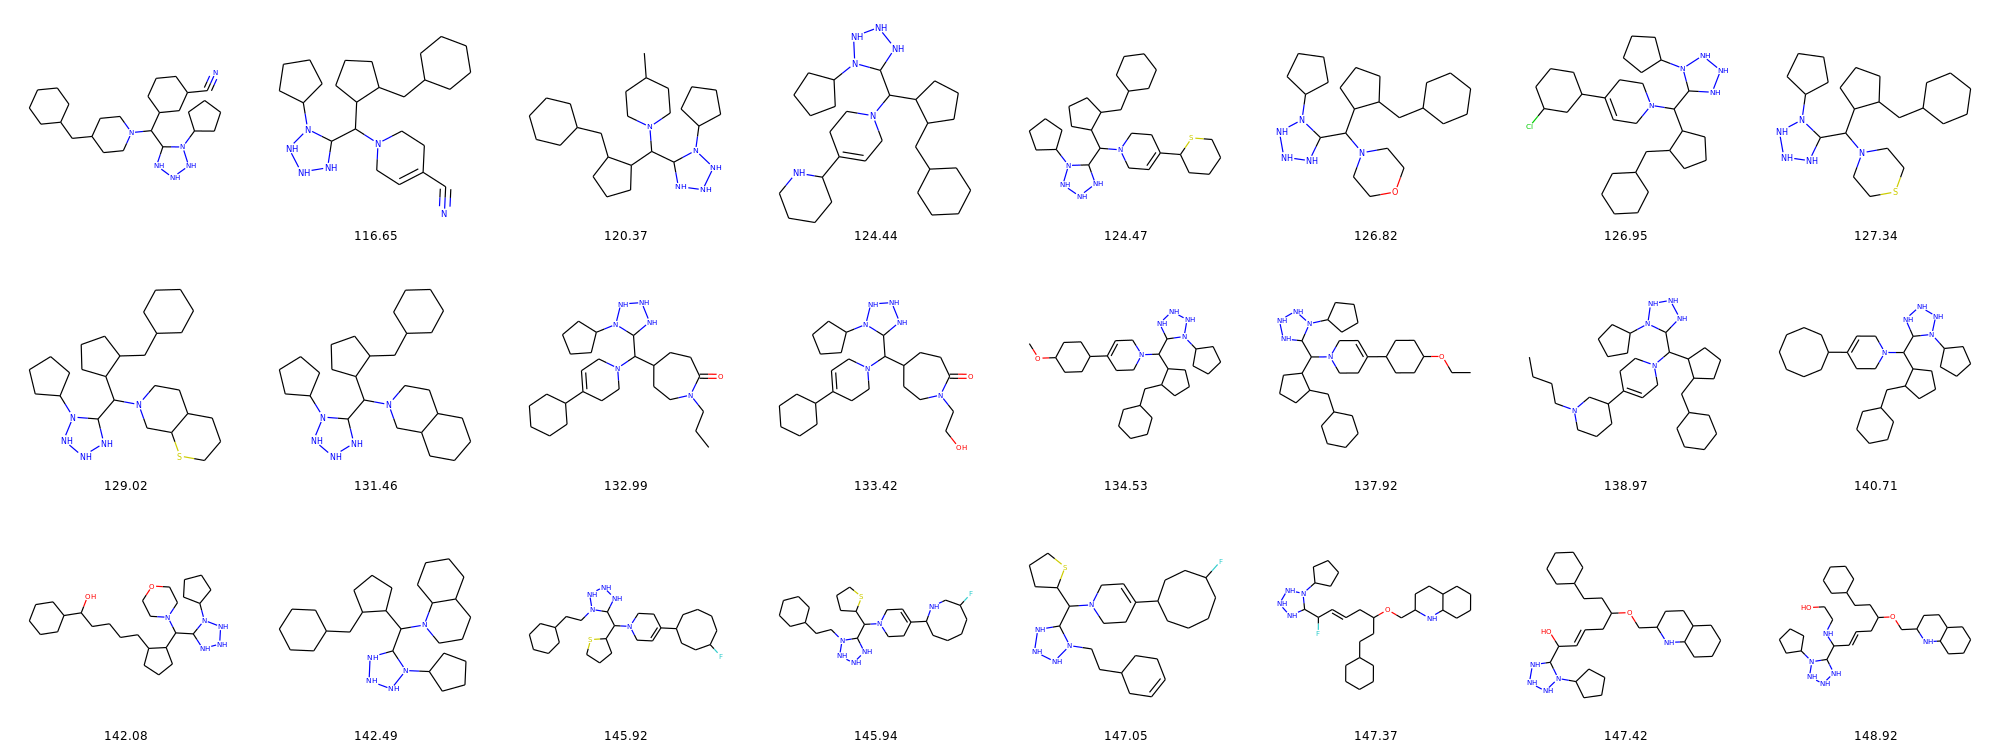

--------------------------------------------------------------------------------
knns
________________________________________________________________________________


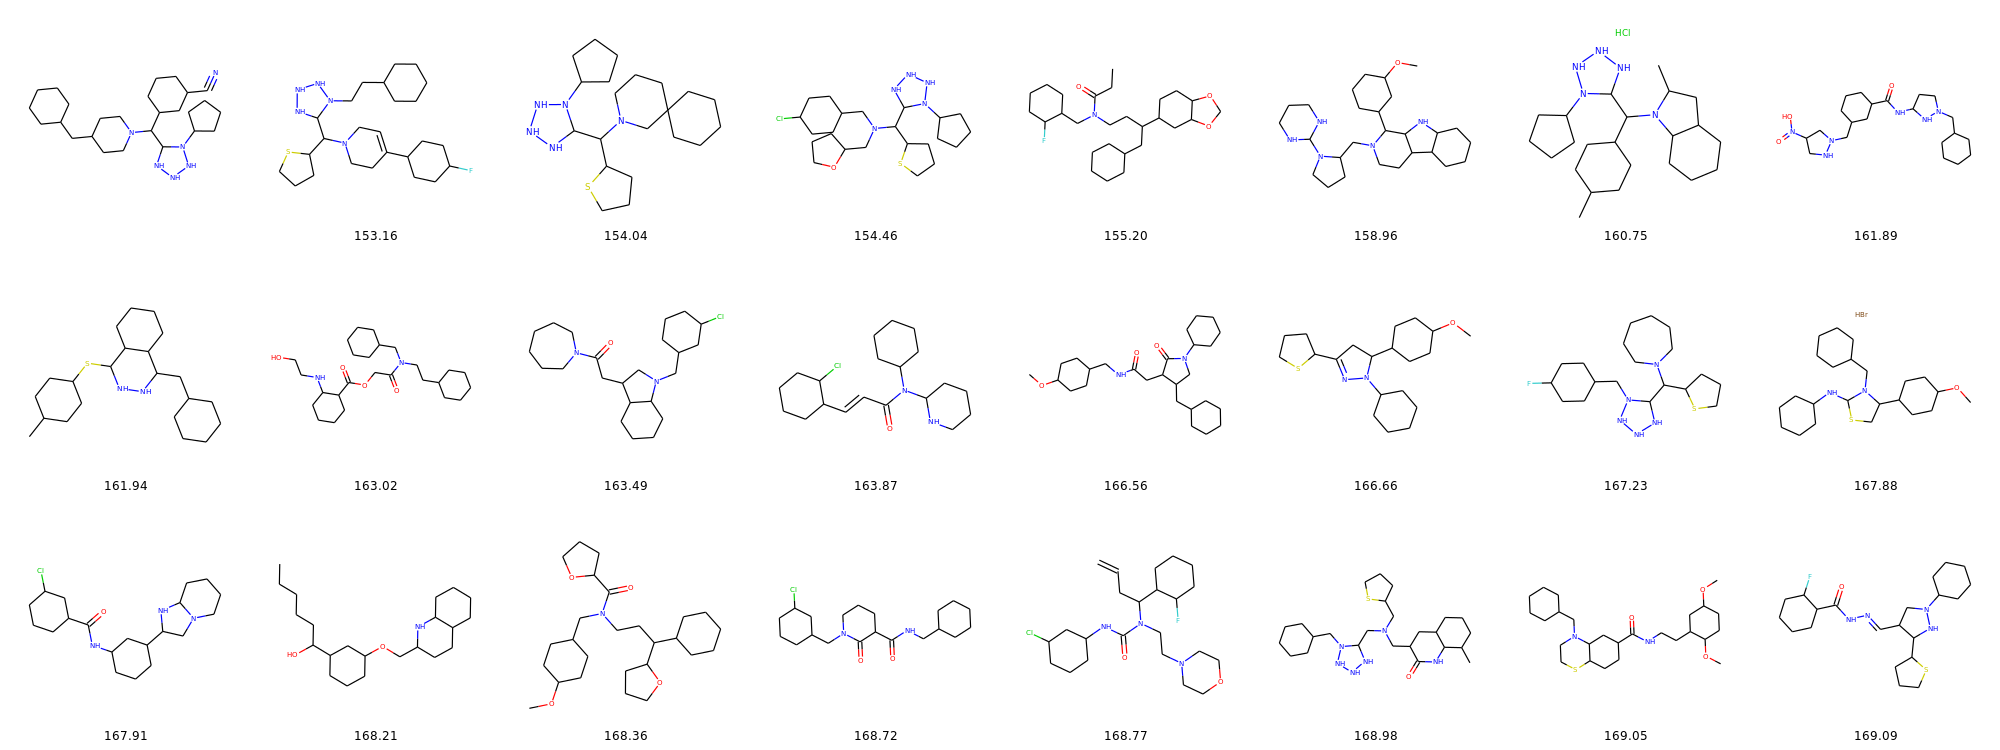

________________________________________________________________________________
iter: 4/4
________________________________________________________________________________
#interfaces:  2910   #cores:  3054   #core-interface-pairs:  4908
fitting: Instances: 7832 ; Features: 65537 with an avg of 2044 per instance
fit  3.29 sec
iter:   0 	current min obj-0:    5.08 	median obj-0:   25.87 	added n neighbors:  904 	obtained pareto set of size:   31 	next round seeds:   10 
iter:   1 	current min obj-0:    5.08 	median obj-0:   31.93 	added n neighbors: 1694 	obtained pareto set of size:   31 	next round seeds:   10 
iter:   2 	current min obj-0:    5.08 	median obj-0:   42.44 	added n neighbors: 1147 	obtained pareto set of size:   31 	next round seeds:    4 
Terminated at iteration:3 because No non visited elements in frontier, stopping
optimize  176.36 sec
--------------------------------------------------------------------------------
target vs candidate vs best vs 1-knn
_______________

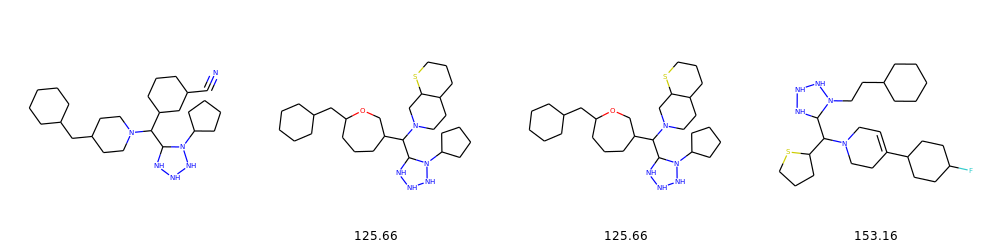

--------------------------------------------------------------------------------
sorted reconstructions
________________________________________________________________________________


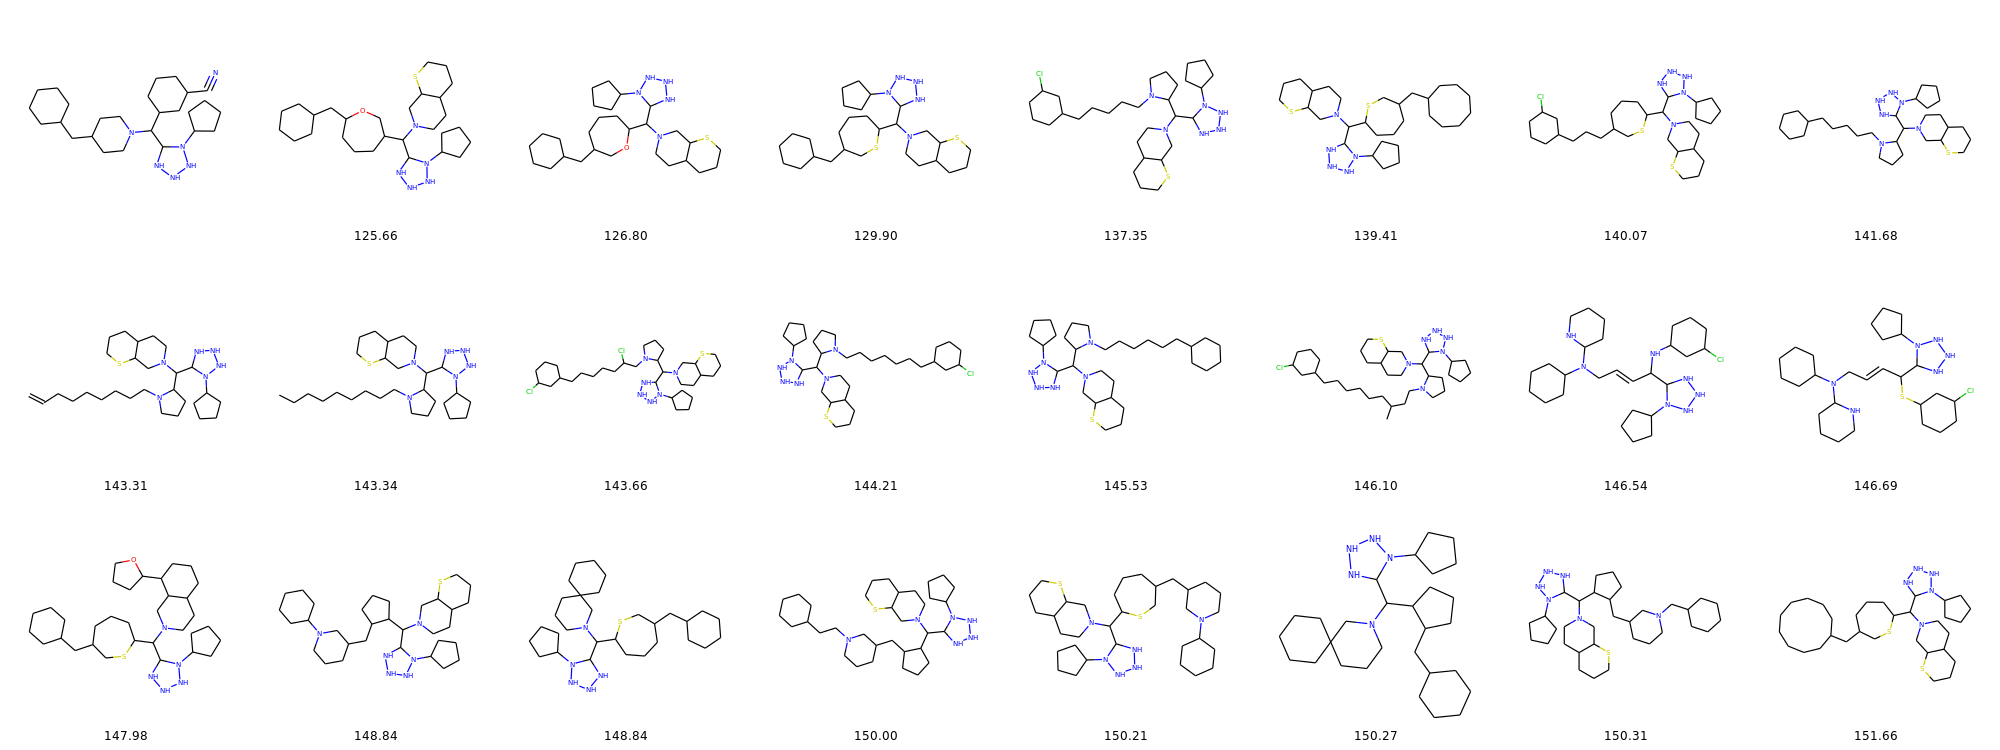

--------------------------------------------------------------------------------
knns
________________________________________________________________________________


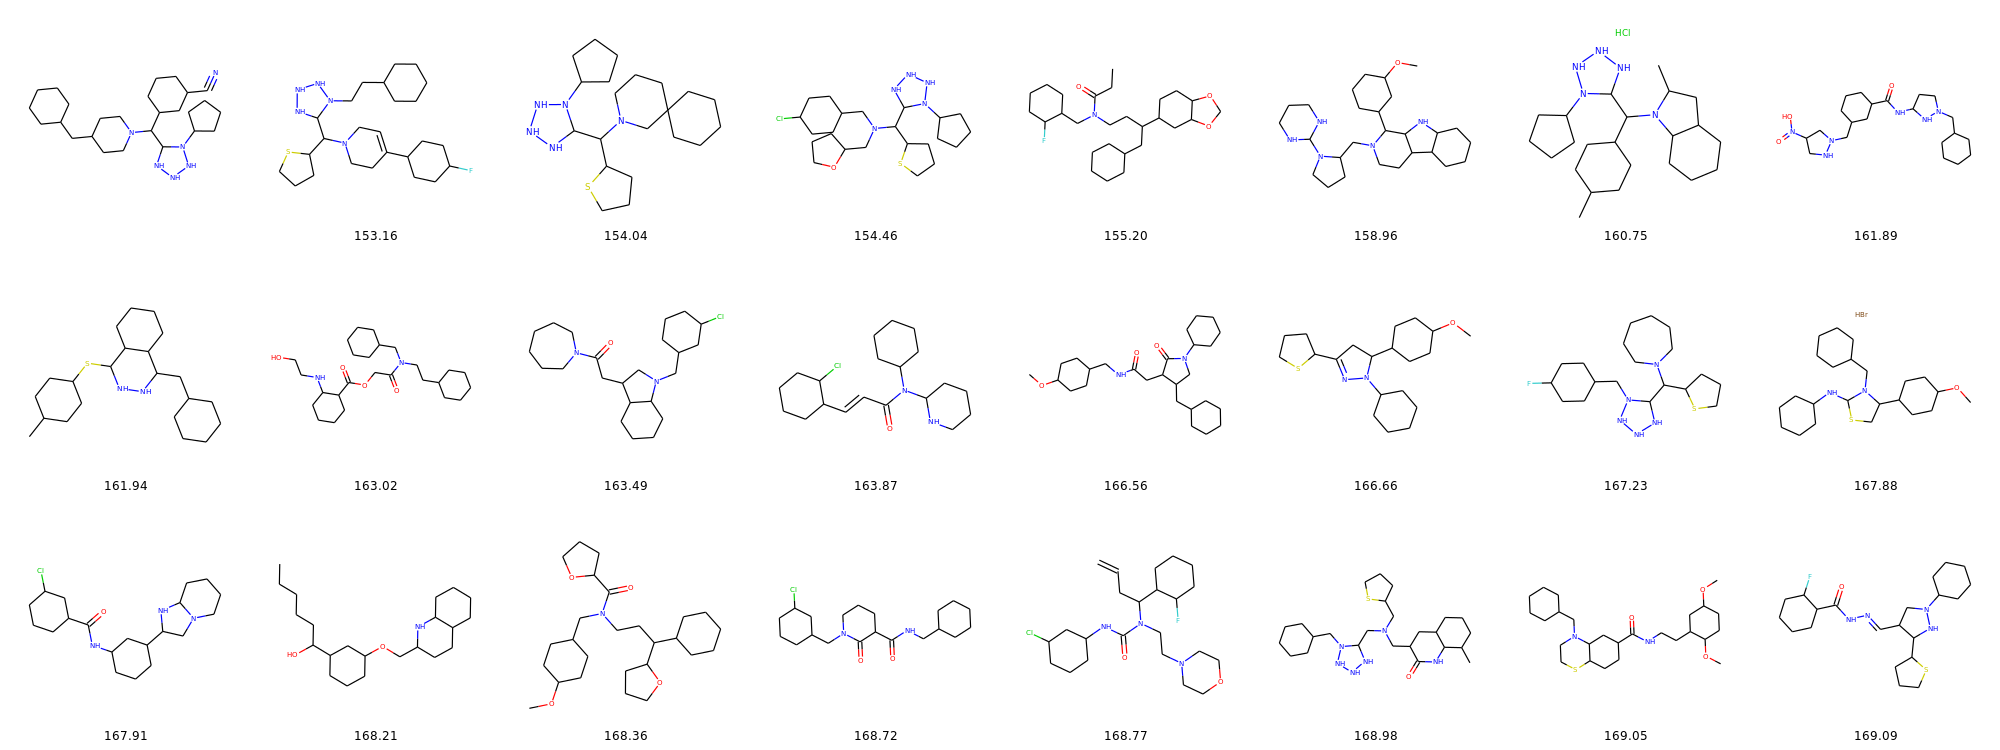




Exp: 3/5
________________________________________________________________________________
iter: 1/4
________________________________________________________________________________
#interfaces:  2540   #cores:  2611   #core-interface-pairs:  4329
fitting: Instances: 7832 ; Features: 65537 with an avg of 1753 per instance
fit  3.01 sec
iter:   0 	current min obj-0:    3.78 	median obj-0:   14.70 	added n neighbors: 2255 	obtained pareto set of size:   32 	next round seeds:   10 
iter:   1 	current min obj-0:    2.91 	median obj-0:   13.86 	added n neighbors: 1710 	obtained pareto set of size:   28 	next round seeds:   10 
iter:   2 	current min obj-0:    2.91 	median obj-0:   13.30 	added n neighbors: 1021 	obtained pareto set of size:   22 	next round seeds:    6 
iter:   3 	current min obj-0:    2.44 	median obj-0:   12.30 	added n neighbors:  638 	obtained pareto set of size:   28 	next round seeds:    9 
iter:   4 	current min obj-0:    1.89 	median obj-0:   12.01 	added n neighb

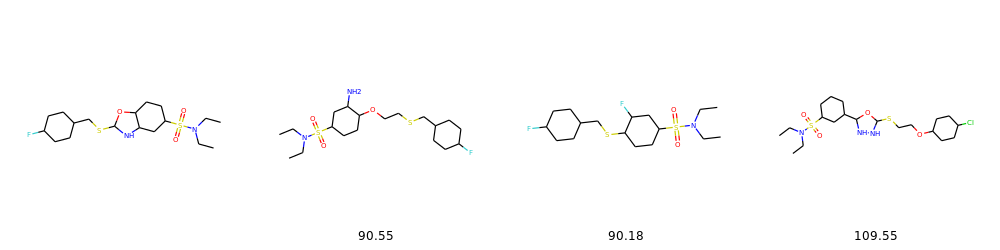

--------------------------------------------------------------------------------
sorted reconstructions
________________________________________________________________________________


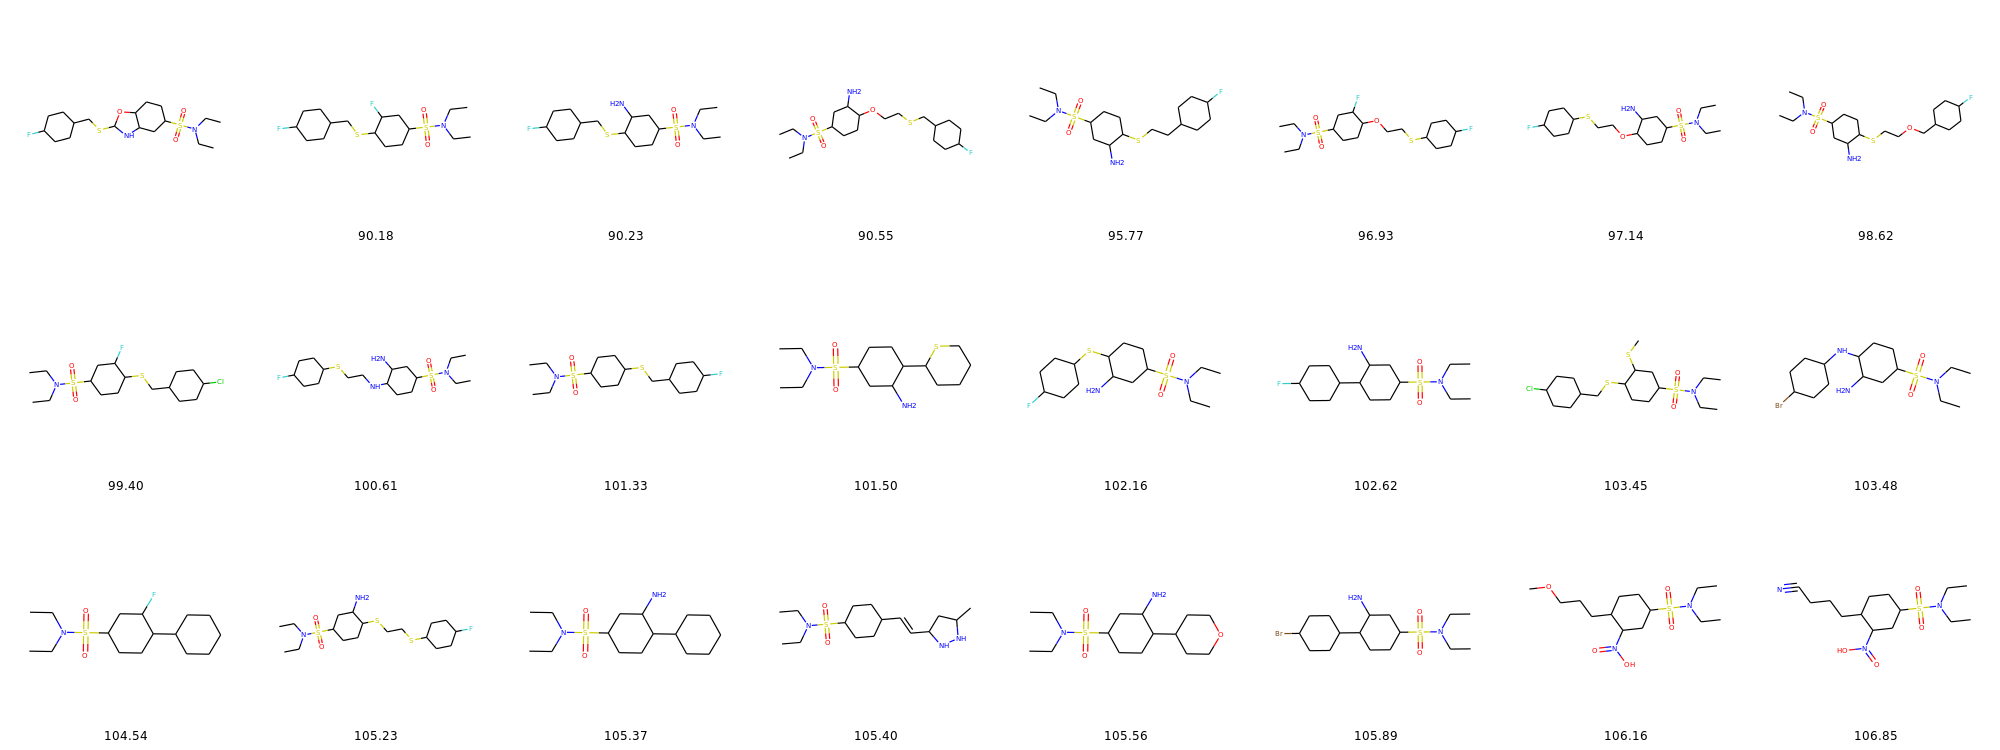

--------------------------------------------------------------------------------
knns
________________________________________________________________________________


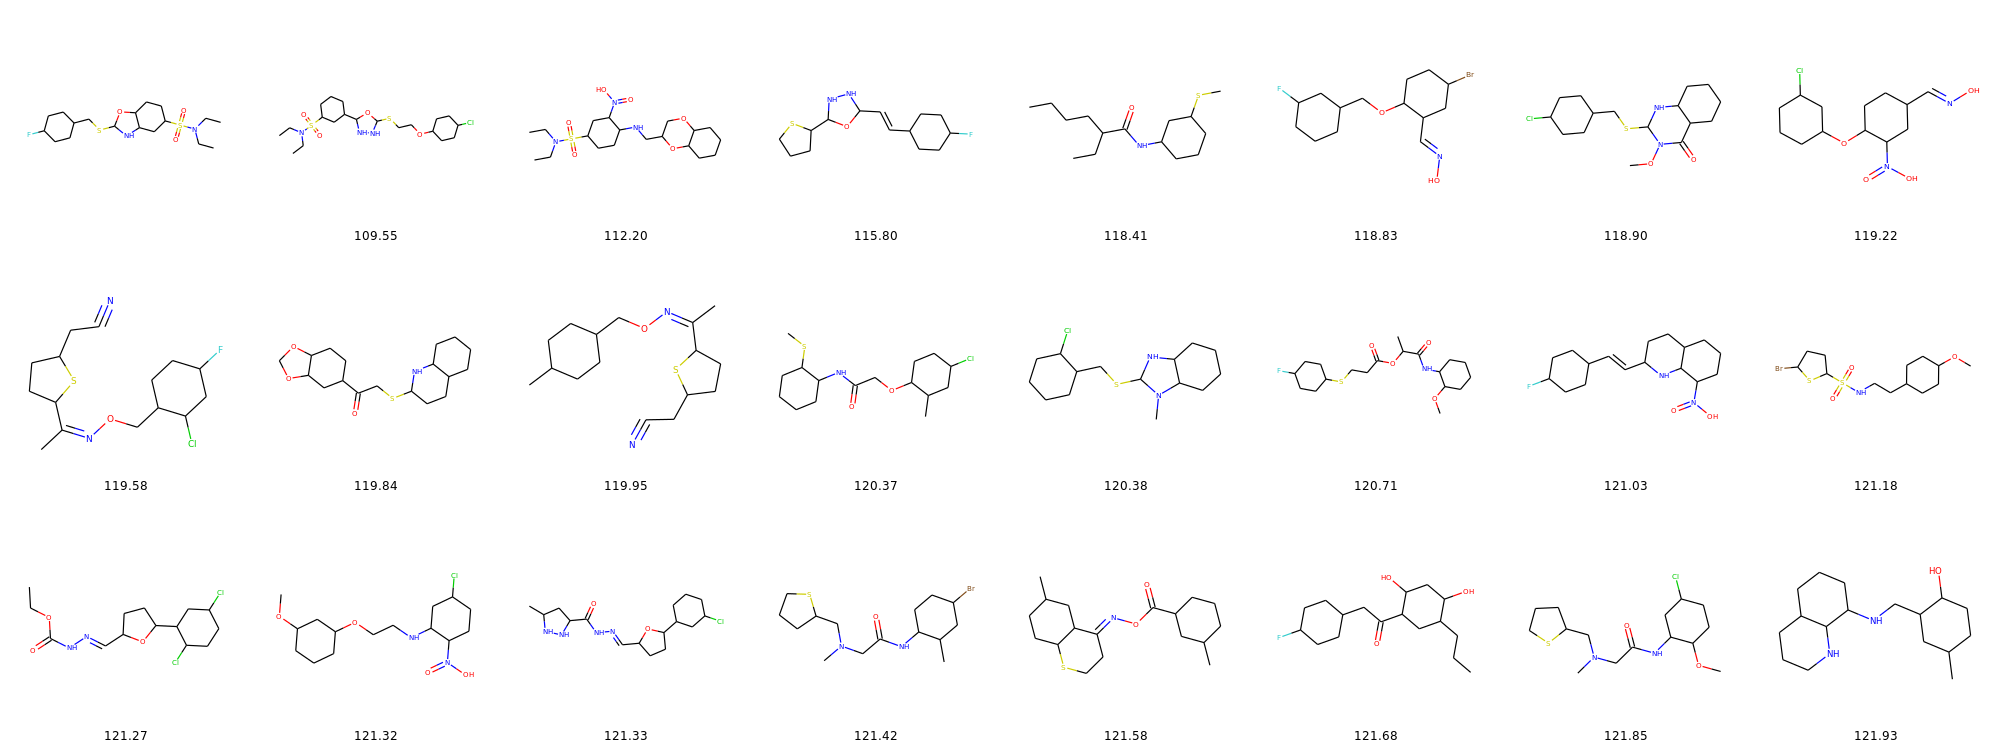

________________________________________________________________________________
iter: 2/4
________________________________________________________________________________
#interfaces:  2540   #cores:  2611   #core-interface-pairs:  4329
fitting: Instances: 7832 ; Features: 65537 with an avg of 1753 per instance
fit  2.78 sec
iter:   0 	current min obj-0:    4.41 	median obj-0:   16.68 	added n neighbors:   76 	obtained pareto set of size:    6 	next round seeds:    6 
iter:   1 	current min obj-0:    4.41 	median obj-0:   16.53 	added n neighbors:   86 	obtained pareto set of size:    7 	next round seeds:    1 
iter:   2 	current min obj-0:    4.41 	median obj-0:    7.12 	added n neighbors:    3 	obtained pareto set of size:    7 	next round seeds:    1 
iter:   3 	current min obj-0:    4.41 	median obj-0:    9.66 	added n neighbors:   19 	obtained pareto set of size:    7 	next round seeds:    1 
Terminated at iteration:4 because No non visited elements in frontier, stopping
optimize

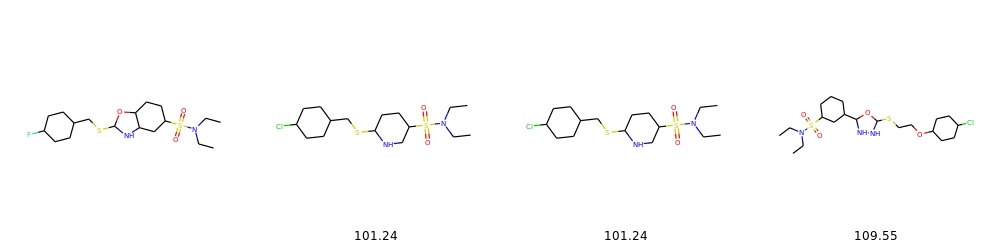

--------------------------------------------------------------------------------
sorted reconstructions
________________________________________________________________________________


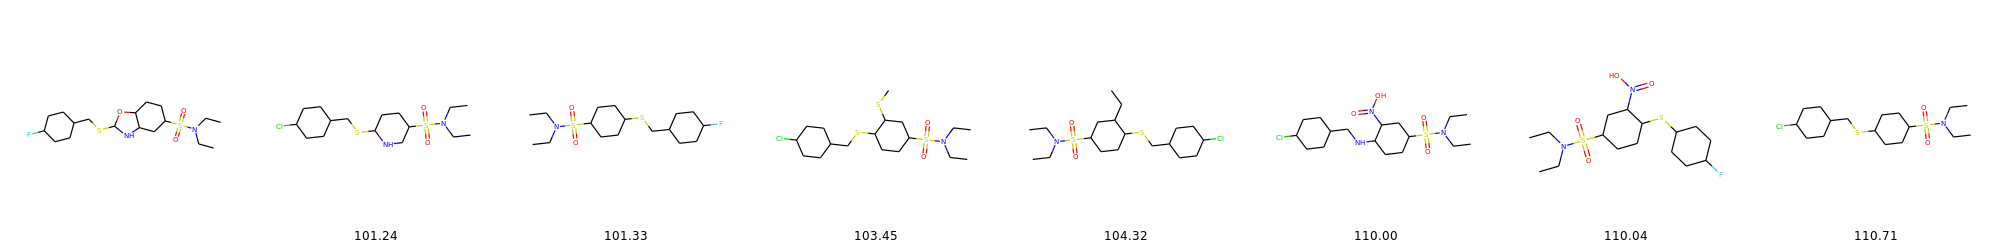

--------------------------------------------------------------------------------
knns
________________________________________________________________________________


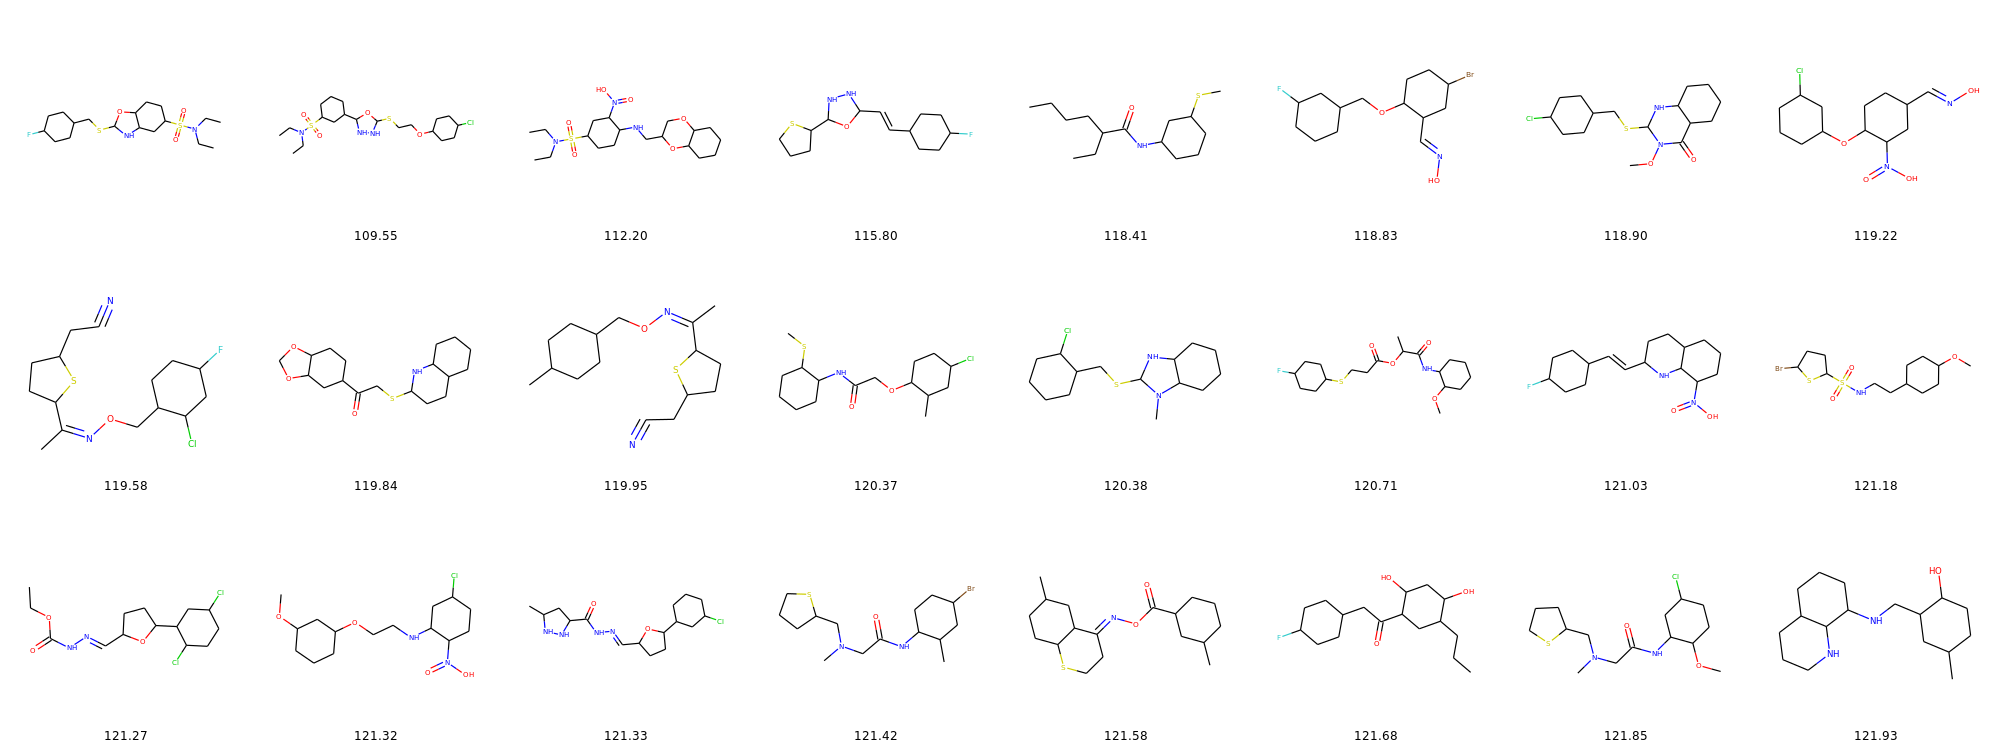

________________________________________________________________________________
iter: 3/4
________________________________________________________________________________
#interfaces:  2540   #cores:  2611   #core-interface-pairs:  4329
fitting: Instances: 7832 ; Features: 65537 with an avg of 1753 per instance
fit  2.79 sec
iter:   0 	current min obj-0:    4.77 	median obj-0:   17.75 	added n neighbors:  241 	obtained pareto set of size:   11 	next round seeds:   10 
iter:   1 	current min obj-0:    4.40 	median obj-0:   21.07 	added n neighbors:  241 	obtained pareto set of size:   13 	next round seeds:    3 
iter:   2 	current min obj-0:    4.40 	median obj-0:   15.37 	added n neighbors:   86 	obtained pareto set of size:   13 	next round seeds:    2 
iter:   3 	current min obj-0:    3.37 	median obj-0:    8.57 	added n neighbors:   28 	obtained pareto set of size:   14 	next round seeds:    2 
iter:   4 	current min obj-0:    3.37 	median obj-0:   16.53 	added n neighbors:   33 	o

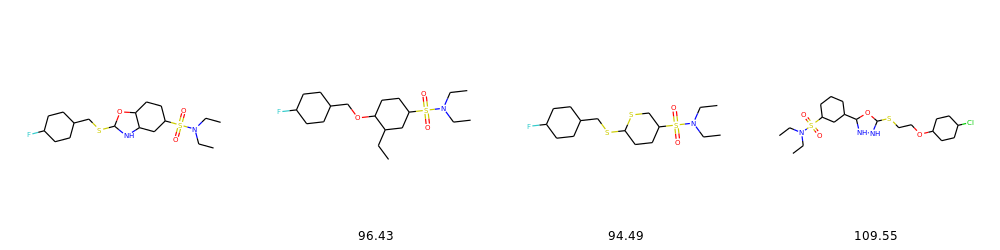

--------------------------------------------------------------------------------
sorted reconstructions
________________________________________________________________________________


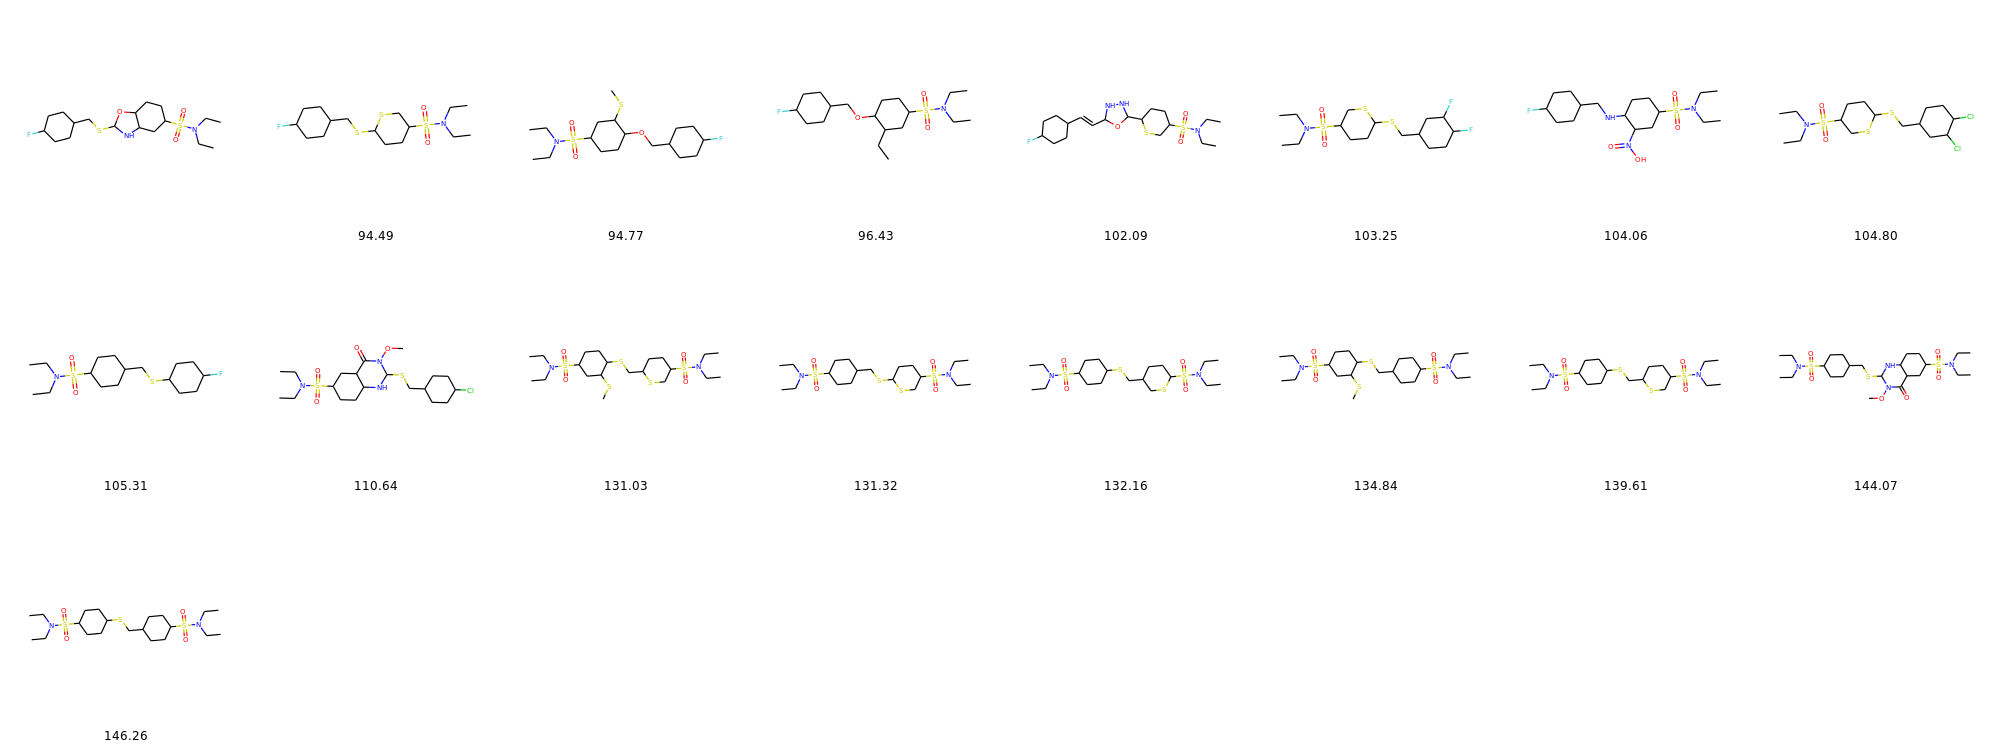

--------------------------------------------------------------------------------
knns
________________________________________________________________________________


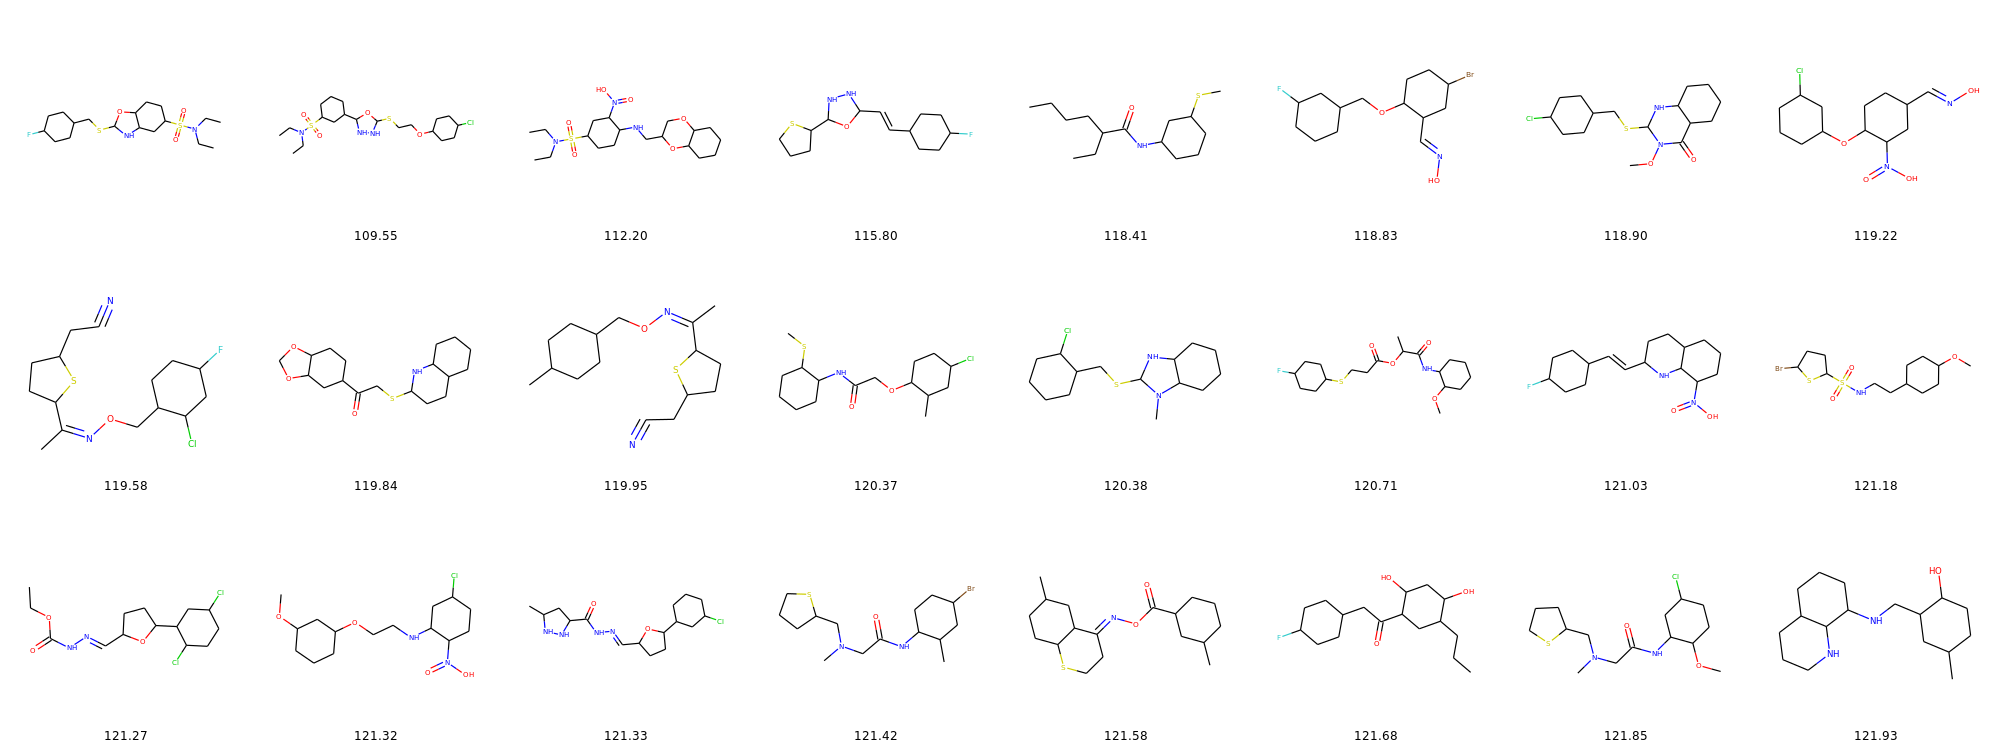

________________________________________________________________________________
iter: 4/4
________________________________________________________________________________
#interfaces:  2540   #cores:  2611   #core-interface-pairs:  4329
fitting: Instances: 7832 ; Features: 65537 with an avg of 1753 per instance
fit  2.77 sec
iter:   0 	current min obj-0:    3.15 	median obj-0:   14.79 	added n neighbors:  615 	obtained pareto set of size:   17 	next round seeds:   10 
iter:   1 	current min obj-0:    3.15 	median obj-0:   21.69 	added n neighbors:  992 	obtained pareto set of size:   23 	next round seeds:   10 
iter:   2 	current min obj-0:    3.15 	median obj-0:   16.16 	added n neighbors:  889 	obtained pareto set of size:   22 	next round seeds:   10 
iter:   3 	current min obj-0:    3.15 	median obj-0:   14.91 	added n neighbors:  562 	obtained pareto set of size:   26 	next round seeds:    8 
iter:   4 	current min obj-0:    2.83 	median obj-0:   13.59 	added n neighbors:  300 	o

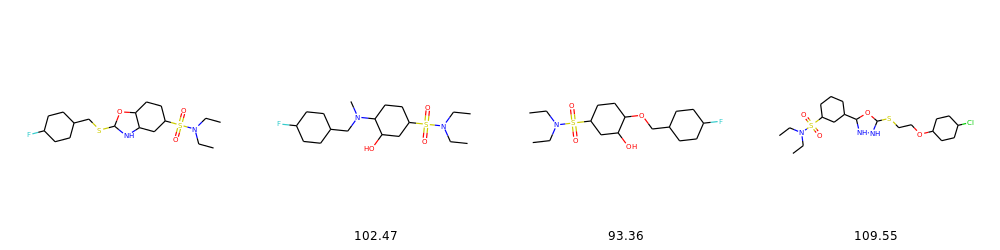

--------------------------------------------------------------------------------
sorted reconstructions
________________________________________________________________________________


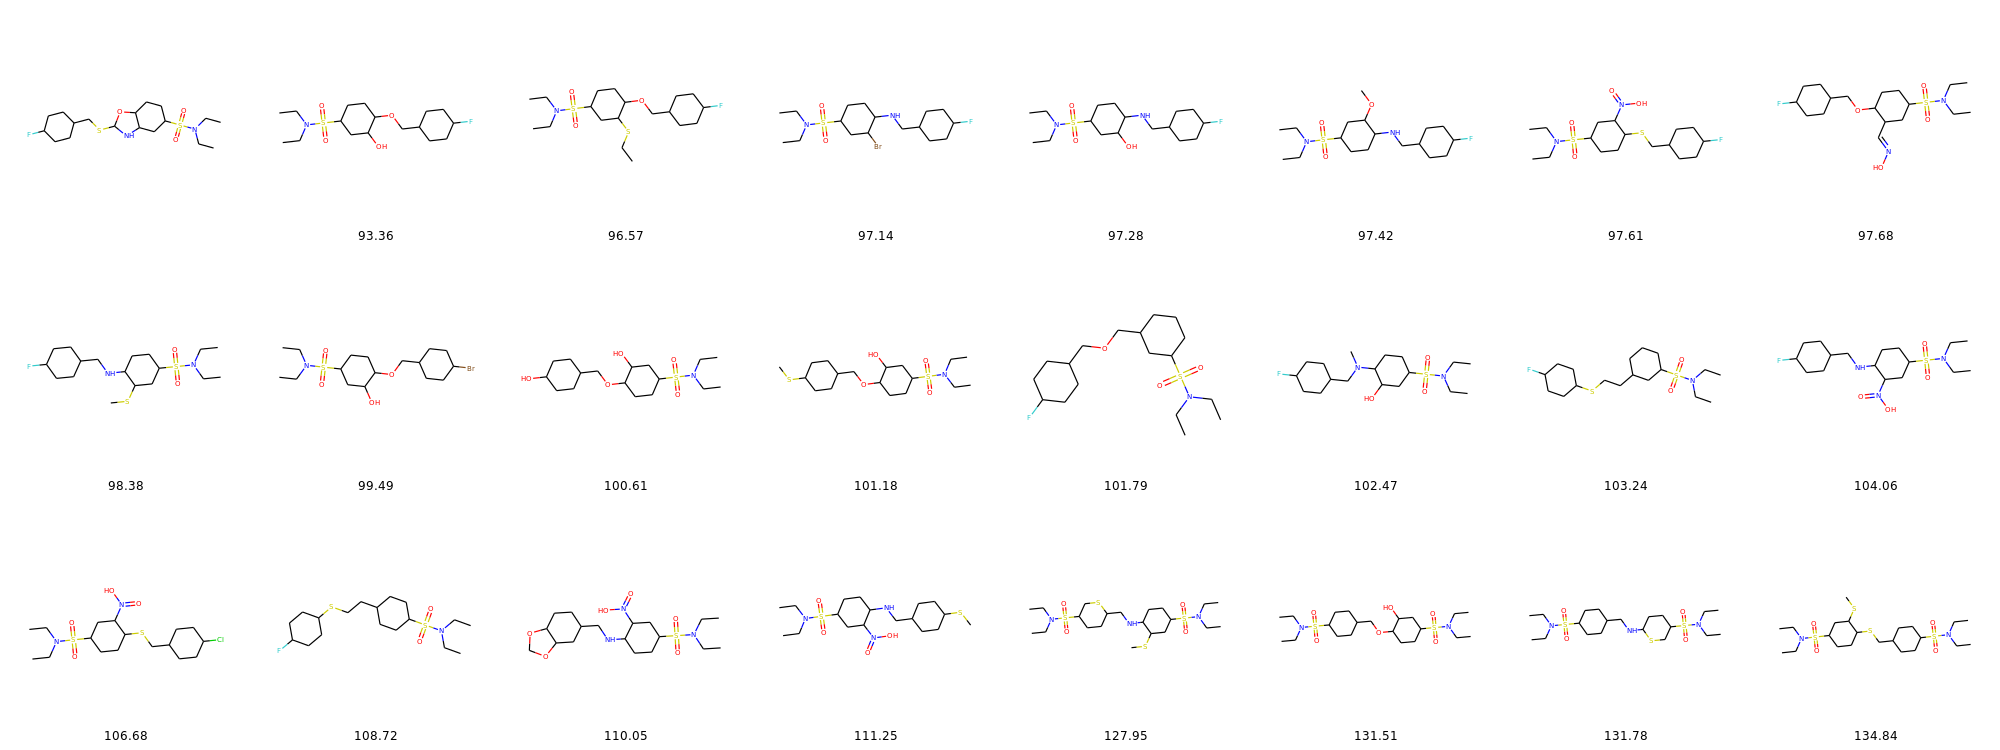

--------------------------------------------------------------------------------
knns
________________________________________________________________________________


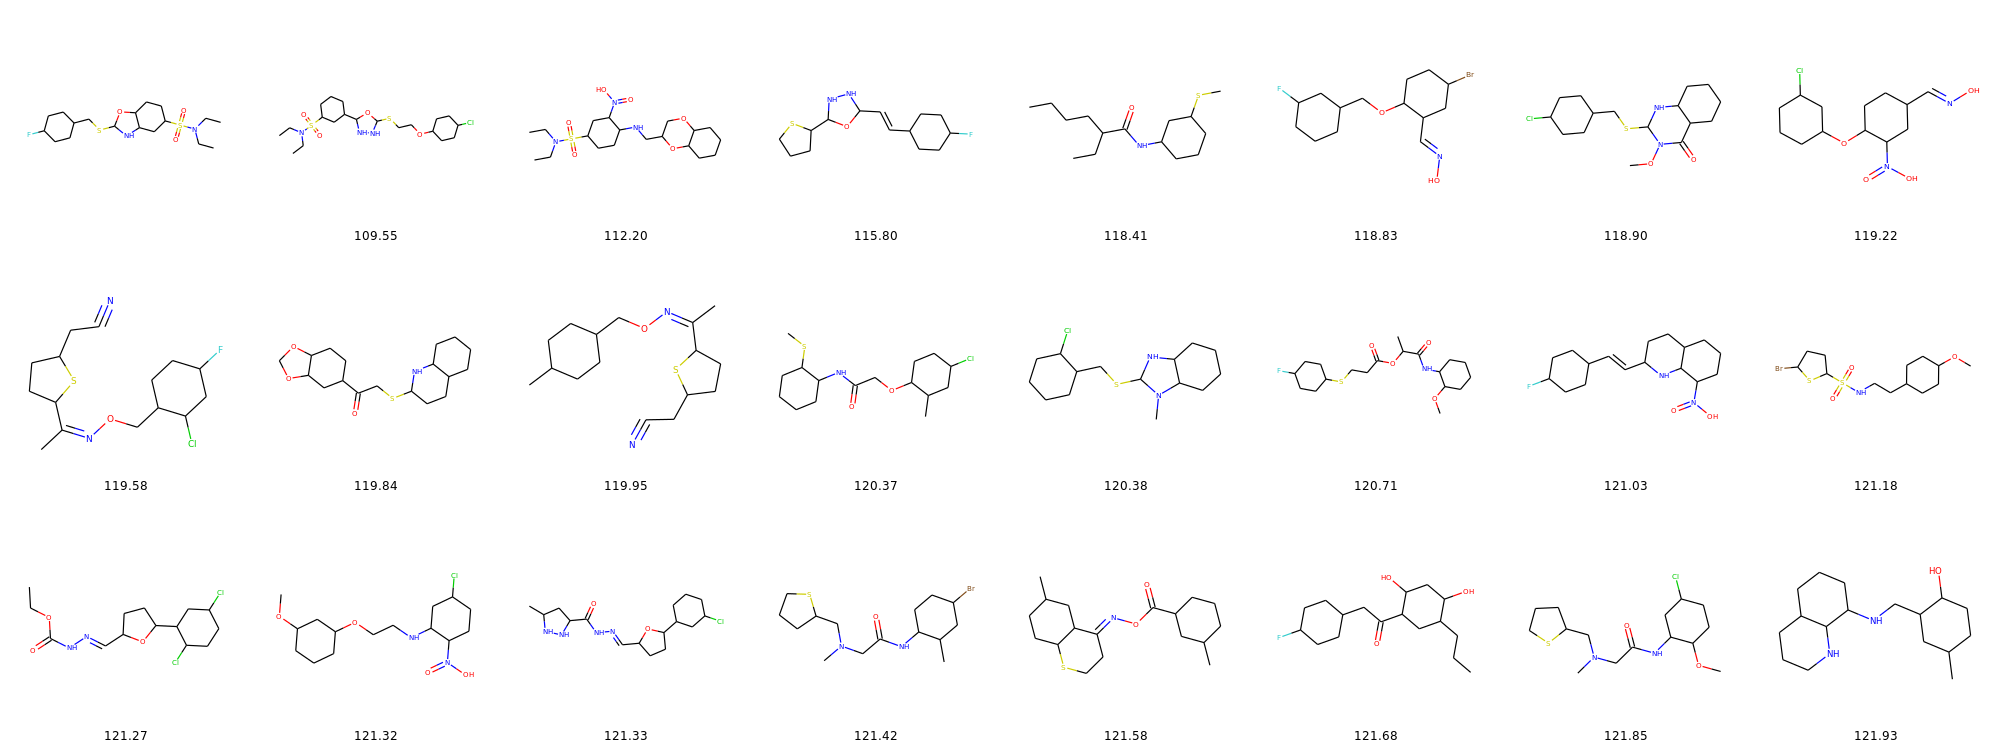




Exp: 4/5
________________________________________________________________________________
iter: 1/4
________________________________________________________________________________
#interfaces:  2668   #cores:  2722   #core-interface-pairs:  4545
fitting: Instances: 7832 ; Features: 65537 with an avg of 1823 per instance
fit  2.84 sec
iter:   0 	current min obj-0:    4.43 	median obj-0:   12.76 	added n neighbors: 1979 	obtained pareto set of size:   31 	next round seeds:   10 
iter:   1 	current min obj-0:    4.43 	median obj-0:   18.56 	added n neighbors:  544 	obtained pareto set of size:   31 	next round seeds:   10 
iter:   2 	current min obj-0:    4.43 	median obj-0:   25.12 	added n neighbors:  357 	obtained pareto set of size:   31 	next round seeds:    6 
iter:   3 	current min obj-0:    4.10 	median obj-0:   35.50 	added n neighbors:  258 	obtained pareto set of size:   31 	next round seeds:    2 
iter:   4 	current min obj-0:    4.10 	median obj-0:   57.90 	added n neighb

In [ ]:
n_iter_per_exp=4
adapt_grammar_n_iter=5
max_size_frontier=30
n_exps = 5


args = dict(
    r=3,d=6,
    min_count=1,
    context_size=2,
    expand_max_n_neighbors=None,
    n_iter=adapt_grammar_n_iter*2,
    expand_max_frontier=max_size_frontier/3, 
    max_size_frontier=max_size_frontier,
    adapt_grammar_n_iter=adapt_grammar_n_iter)


for n in range(n_exps):
    logger.info('\n\n')
    logger.info('Exp: %d/%d' % (n+1, n_exps))
    res = InstanceMaker(n_landmarks=max_size_frontier, n_neighbors=max_size_frontier*3).fit(pos_graphs).sample()
    landmark_graphs, desired_distances, ranked_graphs, target_graph = res
    riconstructions = iter_construct_and_visualize_exp(n_iter_per_exp, target_graph, landmark_graphs, desired_distances, ranked_graphs, args)

---